In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_household_electricity_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    cast_to_float,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_household_electricity_data()
    .pipe(format_datetime, col="Date_Time")
    .pipe(set_index, col="Date_Time")
    .pipe(resample_Data, freq="H")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (2075259, 8)
set_index: DF Shape (2075259, 7)
resample_Data: DF Shape (34589, 7)
dataframe shape (34589, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34589 entries, 2006-12-16 17:00:00 to 2010-11-26 21:00:00
Freq: H
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    34589 non-null  float64
 1   Global_reactive_power  34589 non-null  float64
 2   Voltage                34589 non-null  float64
 3   Global_intensity       34589 non-null  float64
 4   Sub_metering_1         34589 non-null  float64
 5   Sub_metering_2         34589 non-null  float64
 6   Sub_metering_3         34589 non-null  float64
dtypes: float64(7)
memory usage: 2.1 MB
None


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [4]:
dataframe.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

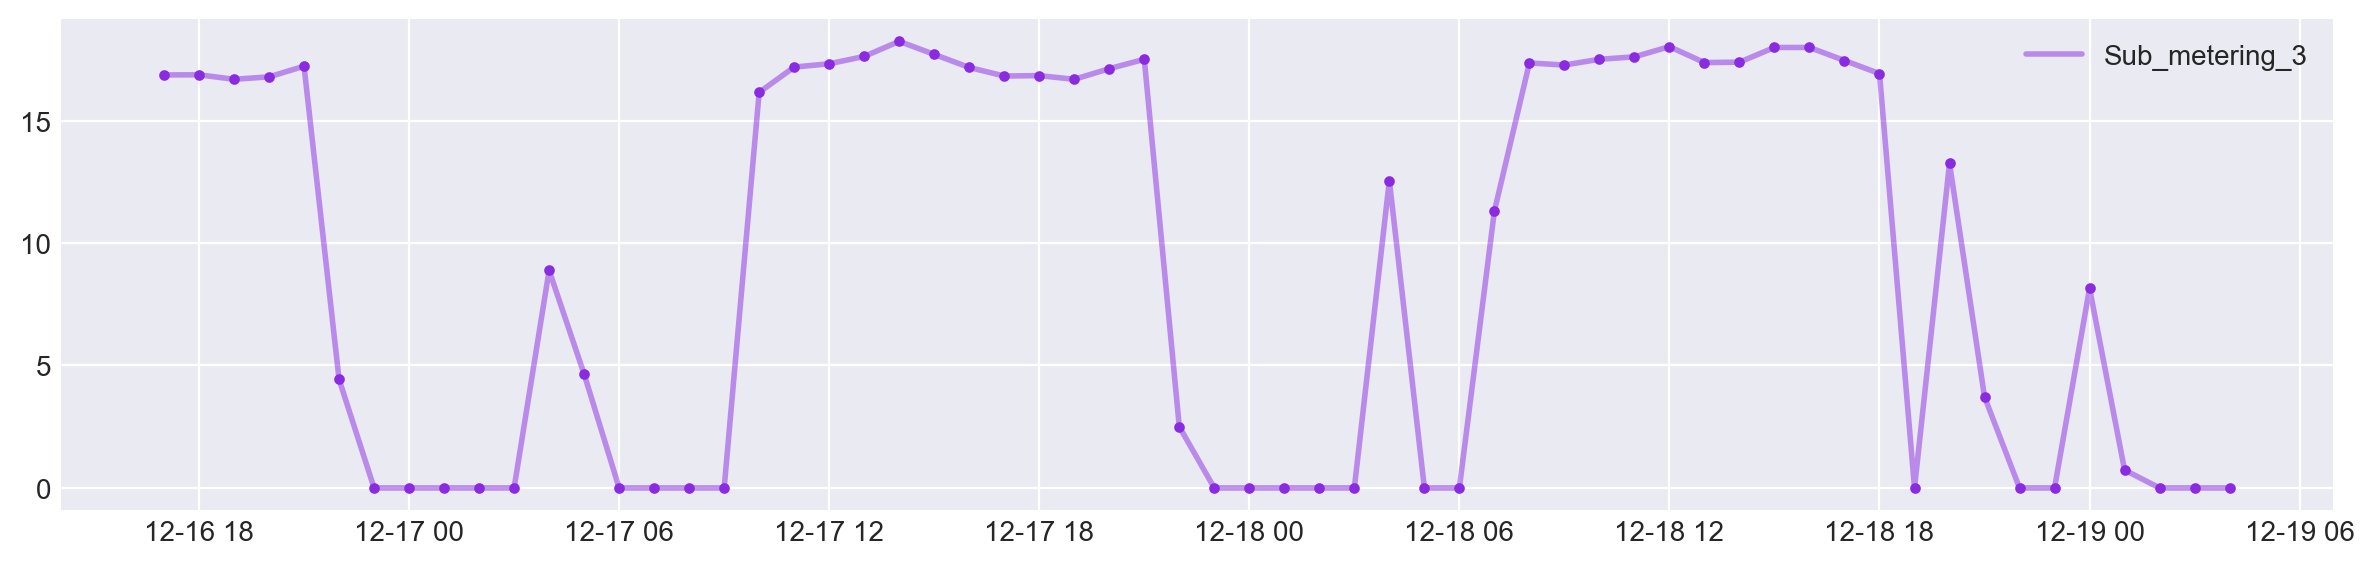

In [5]:
show_dataset(dataframe[:60], columns=["Sub_metering_3"])

In [6]:
dt_features = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
cl_features = ["day", "month", "year"]
lags = [1, 2]
window_length = 3

target_column = "Sub_metering_3"
TEST_SIZE = 30

In [7]:
train_data, test_data = test_train_split(dataframe, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)

train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

print(f"train_data shape after Feature Union {train_data_feat.shape}")
print(f"test_data shape after Feature Union {test_data_feat.shape}")

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)

print(f"train_data shape after Null Removal {train_data_feat.shape}")
print(f"test_data shape after Null Removal {test_data_feat.shape}")

train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

test_data_feat.head()

Train Size after Test_Train Split: (34559, 7)
Test  Size after Test_Train Split: (30, 7) 
train_data shape after Feature Union (34559, 26)
test_data shape after Feature Union (30, 26)
train_data shape after Null Removal (34557, 26)
test_data shape after Null Removal (30, 26)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_3_lag_1,Sub_metering_3_lag_2,Sub_metering_3_mean_window_3,...,dayofmonth,weekofyear,is_week_end,is_week_day,sin_day,cos_day,sin_month,cos_month,sin_year,cos_year
Date_Time,,,,,,,,,,,,,,,,,,,,,
2010-11-25 16:00:00,0.541800,0.090467,242.954833,2.256667,0.0,0.500000,0.000000,0.000000,0.000000,1.927778,...,25.0,47.0,0.0,1.0,-0.132352,0.991203,-0.99999,0.004426,0.762539,-0.646942
2010-11-25 17:00:00,1.480100,0.052333,238.264000,6.160000,0.0,0.000000,0.000000,0.000000,0.000000,1.927778,...,25.0,47.0,0.0,1.0,-0.132352,0.991203,-0.99999,0.004426,0.762539,-0.646942
2010-11-25 18:00:00,2.211600,0.083833,236.062500,9.343333,0.0,0.000000,5.783333,0.000000,0.000000,1.927778,...,25.0,47.0,0.0,1.0,-0.132352,0.991203,-0.99999,0.004426,0.762539,-0.646942
2010-11-25 19:00:00,2.330467,0.151567,237.729667,9.800000,0.0,0.666667,8.366667,5.783333,0.000000,4.716667,...,25.0,47.0,0.0,1.0,-0.132352,0.991203,-0.99999,0.004426,0.762539,-0.646942
2010-11-25 20:00:00,1.647833,0.098033,241.659000,6.826667,0.0,0.550000,0.000000,8.366667,5.783333,4.716667,...,25.0,47.0,0.0,1.0,-0.132352,0.991203,-0.99999,0.004426,0.762539,-0.646942


In [8]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ..........regressor__n_neighbors=2;, score=0.786 total time=   0.1s
[CV 2/3] END ..........regressor__n_neighbors=2;, score=0.811 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.820 total time=   0.2s
[CV 1/3] END ..........regressor__n_neighbors=3;, score=0.806 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=3;, score=0.820 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.837 total time=   0.2s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.816 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.827 total time=   0.1s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.845 total time=   0.2s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.815 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.829 total time=   0.2s
[CV 3/3] END ..........regressor__n_neighbors=7;,

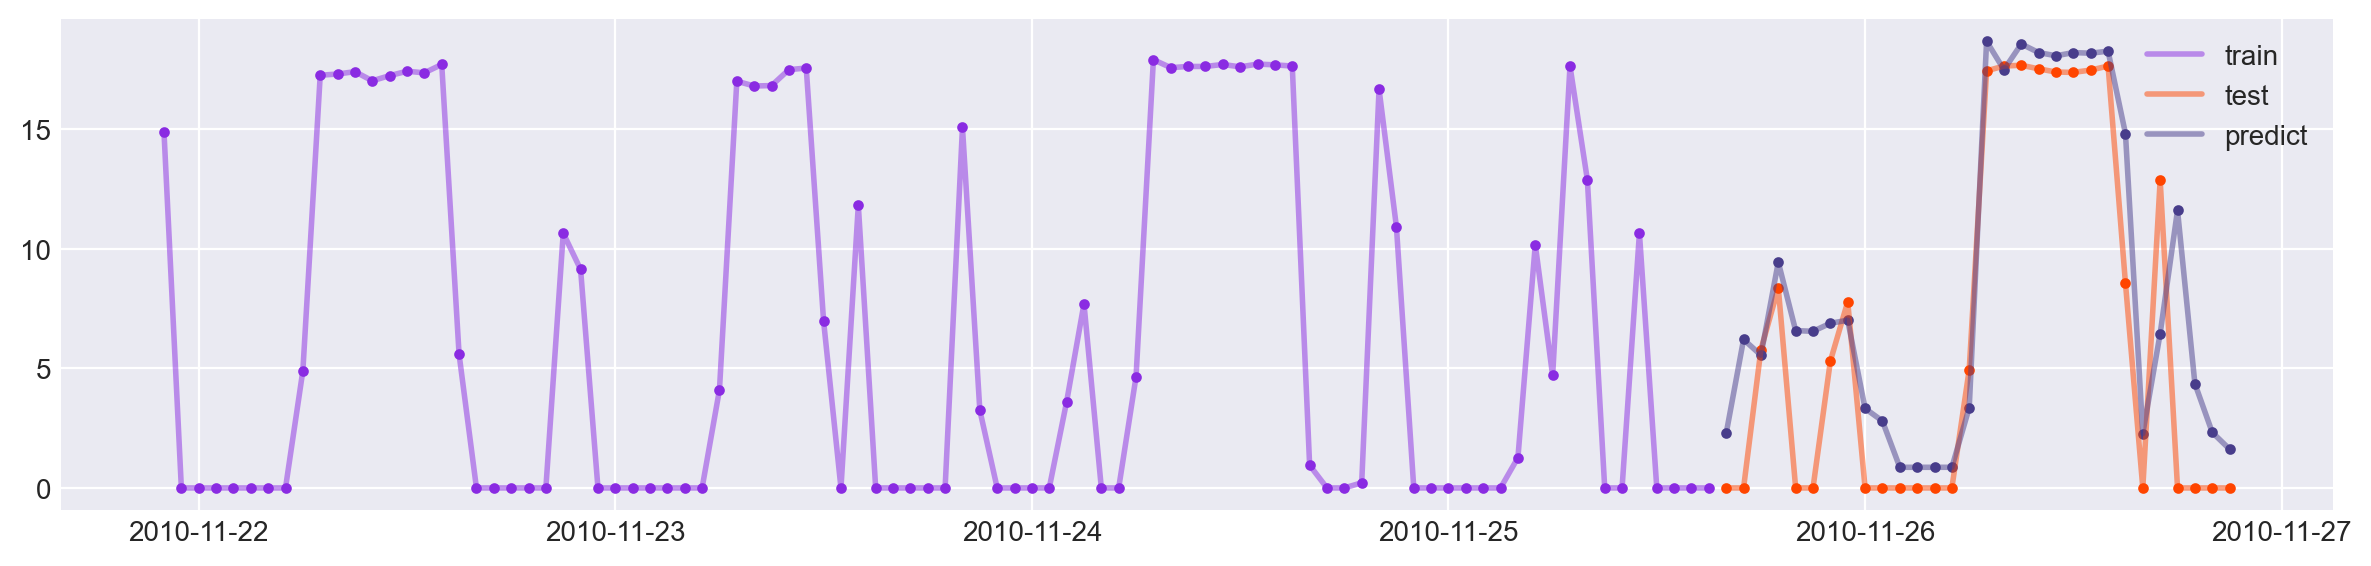

In [10]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [11]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  2  iterations


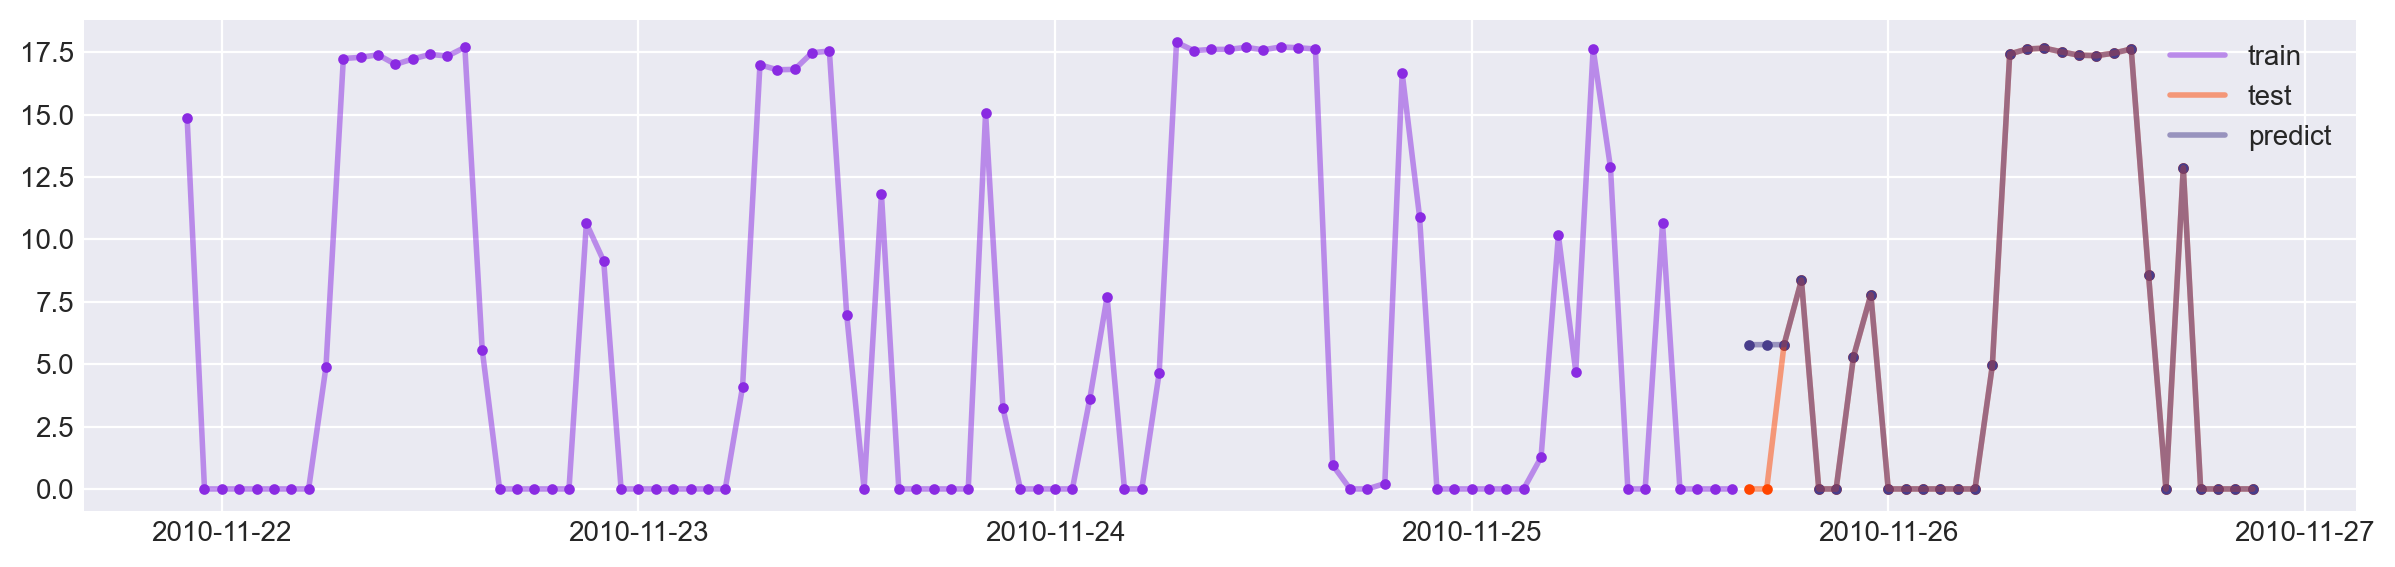

In [12]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [13]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

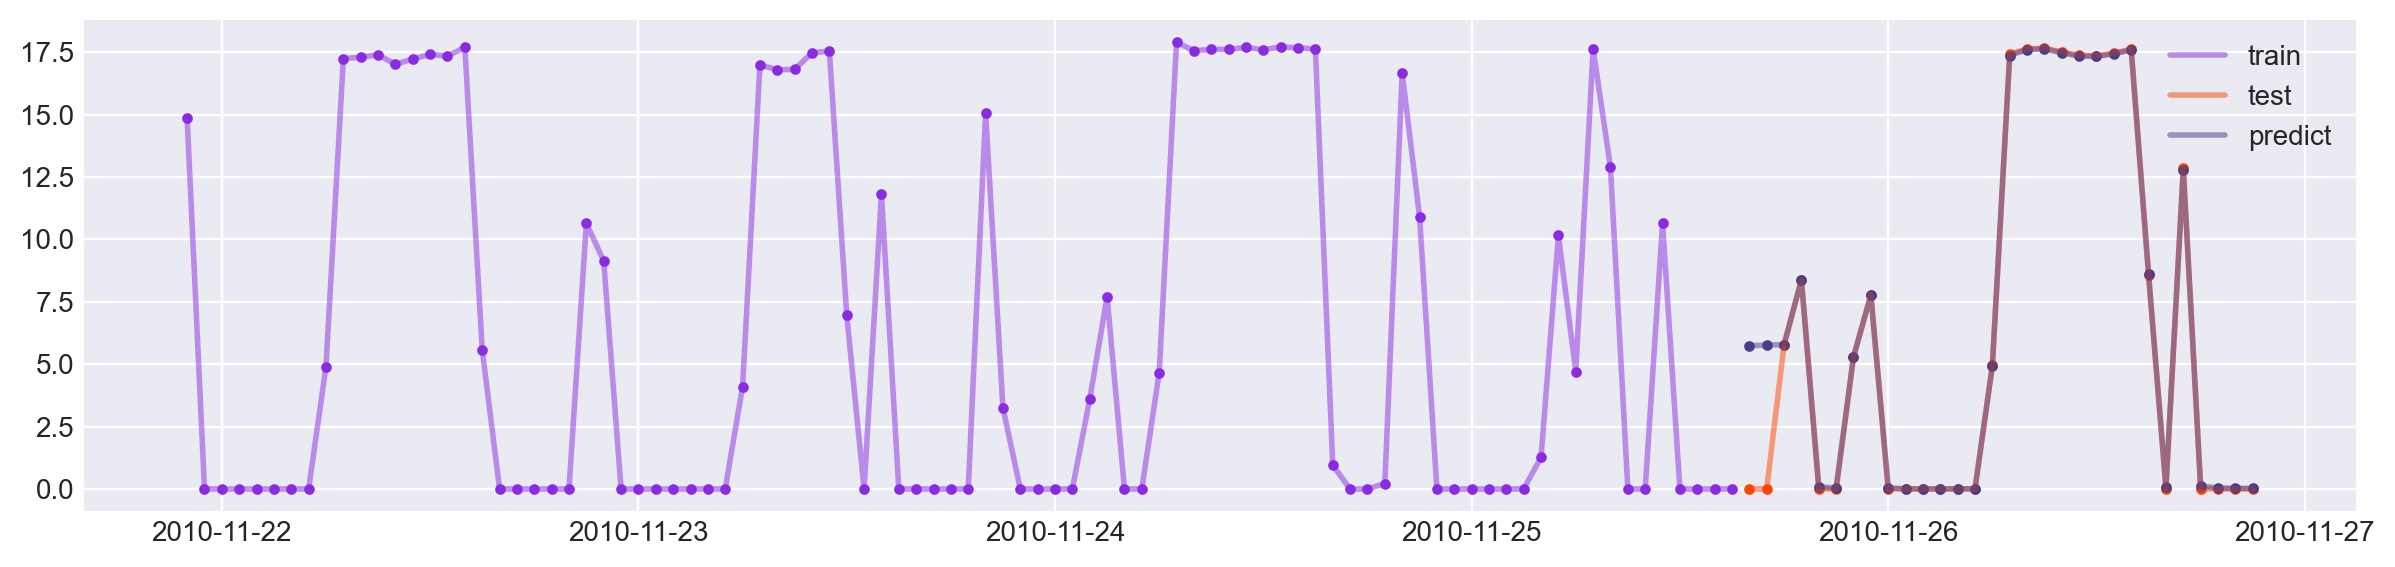

In [14]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor


model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# best Params {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [3],
    "min_samples_split": [7],
    "n_estimators": [600],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.952 total time= 1.4min
[CV 2/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.981 total time= 5.8min
[CV 3/3] END max_depth=9, min_samples_leaf=3, min_samples_split=7, n_estimators=600;, score=0.985 total time= 5.2min
0.9725703852314106 {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 600}


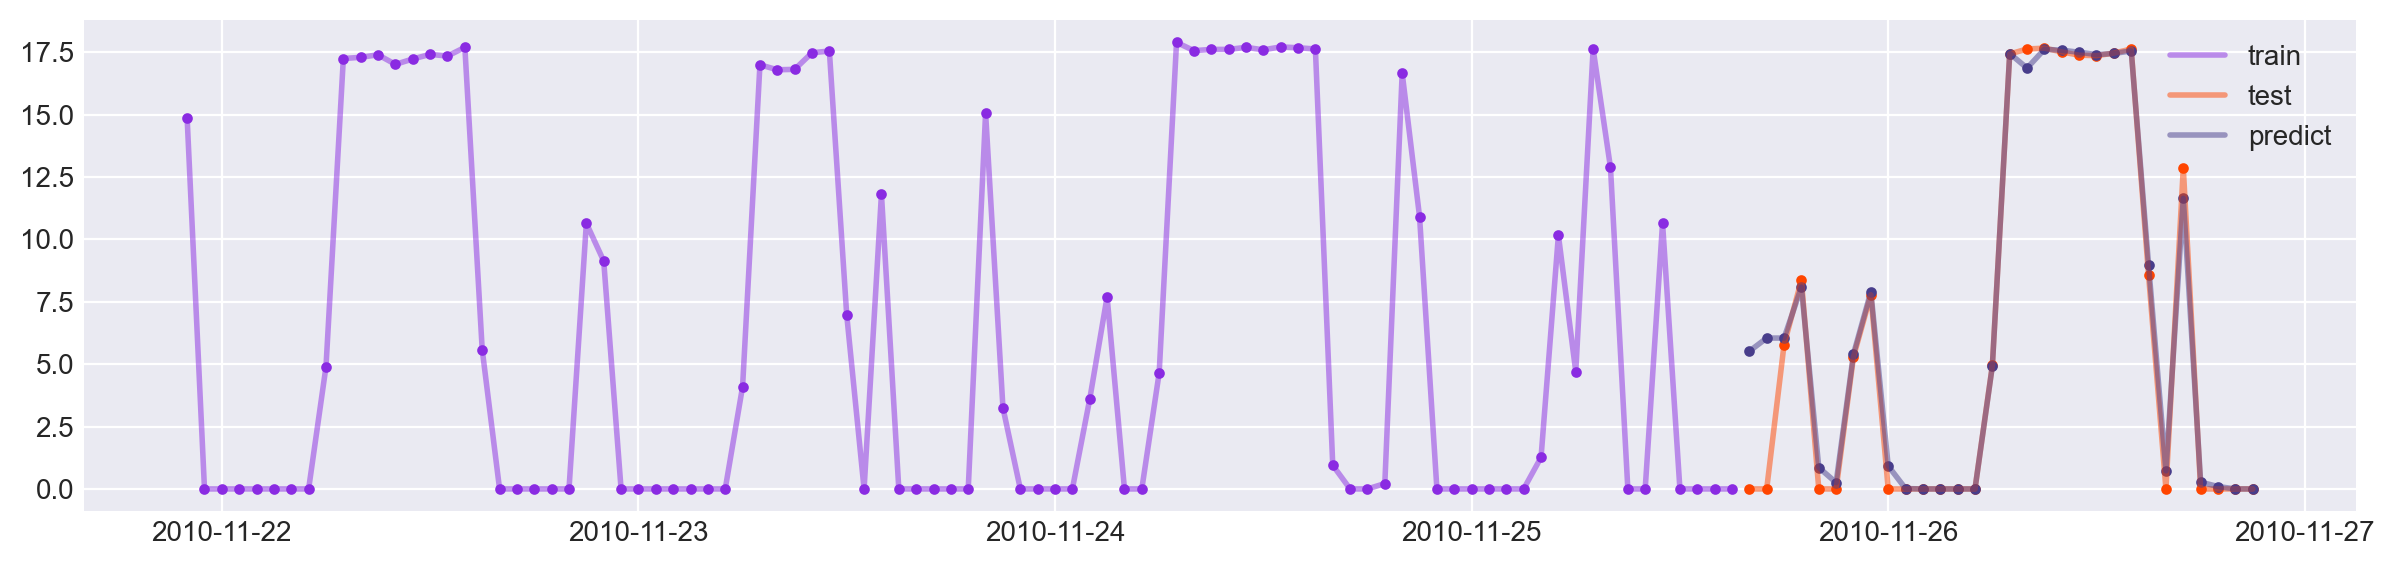

In [16]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:6.11546	validation_1-mae:6.40033
[1]	validation_0-mae:6.05695	validation_1-mae:6.34433
[2]	validation_0-mae:5.99935	validation_1-mae:6.28857
[3]	validation_0-mae:5.94233	validation_1-mae:6.23438
[4]	validation_0-mae:5.88573	validation_1-mae:6.17945
[5]	validation_0-mae:5.82971	validation_1-mae:6.12530
[6]	validation_0-mae:5.77428	validation_1-mae:6.07056
[7]	validation_0-mae:5.71936	validation_1-mae:6.01671
[8]	validation_0-mae:5.66538	validation_1-mae:5.96351
[9]	validation_0-mae:5.61170	validation_1-mae:5.91107
[10]	validation_0-mae:5.55875	validation_1-mae:5.86005
[11]	validation_0-mae:5.50636	validation_1-mae:5.80813
[12]	validation_0-mae:5.45454	validation_1-mae:5.75801
[13]	validation_0-mae:5.40354	validation_1-mae:5.70713
[14]	validation_0-mae:5.35232	validation_1-mae:5.65643
[15]	validation_0-mae:5.30197	validation_1-mae:5.60681
[16]	validation_0-mae:5.25236	validation_1-mae:5.55777
[17]	validation_0-mae:5.20297	validation_1-mae:5.50782
[18]	validation_0-ma

[149]	validation_0-mae:1.65392	validation_1-mae:1.81950
[150]	validation_0-mae:1.64071	validation_1-mae:1.80544
[151]	validation_0-mae:1.62746	validation_1-mae:1.79330
[152]	validation_0-mae:1.61459	validation_1-mae:1.77941
[153]	validation_0-mae:1.60143	validation_1-mae:1.76598
[154]	validation_0-mae:1.58880	validation_1-mae:1.75285
[155]	validation_0-mae:1.57617	validation_1-mae:1.74045
[156]	validation_0-mae:1.56382	validation_1-mae:1.72769
[157]	validation_0-mae:1.55140	validation_1-mae:1.71448
[158]	validation_0-mae:1.53921	validation_1-mae:1.70201
[159]	validation_0-mae:1.52709	validation_1-mae:1.68943
[160]	validation_0-mae:1.51523	validation_1-mae:1.67778
[161]	validation_0-mae:1.50314	validation_1-mae:1.66485
[162]	validation_0-mae:1.49128	validation_1-mae:1.65325
[163]	validation_0-mae:1.47960	validation_1-mae:1.64060
[164]	validation_0-mae:1.46802	validation_1-mae:1.62779
[165]	validation_0-mae:1.45649	validation_1-mae:1.61557
[166]	validation_0-mae:1.44485	validation_1-mae:

[296]	validation_0-mae:0.58366	validation_1-mae:0.70788
[297]	validation_0-mae:0.58026	validation_1-mae:0.70488
[298]	validation_0-mae:0.57703	validation_1-mae:0.70136
[299]	validation_0-mae:0.57370	validation_1-mae:0.69819
[300]	validation_0-mae:0.57036	validation_1-mae:0.69465
[301]	validation_0-mae:0.56729	validation_1-mae:0.69210
[302]	validation_0-mae:0.56423	validation_1-mae:0.68925
[303]	validation_0-mae:0.56126	validation_1-mae:0.68643
[304]	validation_0-mae:0.55808	validation_1-mae:0.68360
[305]	validation_0-mae:0.55509	validation_1-mae:0.68003
[306]	validation_0-mae:0.55201	validation_1-mae:0.67735
[307]	validation_0-mae:0.54894	validation_1-mae:0.67461
[308]	validation_0-mae:0.54598	validation_1-mae:0.67145
[309]	validation_0-mae:0.54294	validation_1-mae:0.66851
[310]	validation_0-mae:0.54004	validation_1-mae:0.66587
[311]	validation_0-mae:0.53733	validation_1-mae:0.66316
[312]	validation_0-mae:0.53445	validation_1-mae:0.66036
[313]	validation_0-mae:0.53151	validation_1-mae:

[443]	validation_0-mae:0.32966	validation_1-mae:0.52331
[444]	validation_0-mae:0.32889	validation_1-mae:0.52317
[445]	validation_0-mae:0.32817	validation_1-mae:0.52297
[446]	validation_0-mae:0.32749	validation_1-mae:0.52267
[447]	validation_0-mae:0.32663	validation_1-mae:0.52260
[448]	validation_0-mae:0.32587	validation_1-mae:0.52268
[449]	validation_0-mae:0.32520	validation_1-mae:0.52236
[450]	validation_0-mae:0.32451	validation_1-mae:0.52176
[451]	validation_0-mae:0.32384	validation_1-mae:0.52168
[452]	validation_0-mae:0.32323	validation_1-mae:0.52162
[453]	validation_0-mae:0.32242	validation_1-mae:0.52162
[454]	validation_0-mae:0.32171	validation_1-mae:0.52174
[455]	validation_0-mae:0.32108	validation_1-mae:0.52187
[456]	validation_0-mae:0.32031	validation_1-mae:0.52177
[457]	validation_0-mae:0.31969	validation_1-mae:0.52161
[458]	validation_0-mae:0.31901	validation_1-mae:0.52172
[459]	validation_0-mae:0.31841	validation_1-mae:0.52169
[460]	validation_0-mae:0.31782	validation_1-mae:

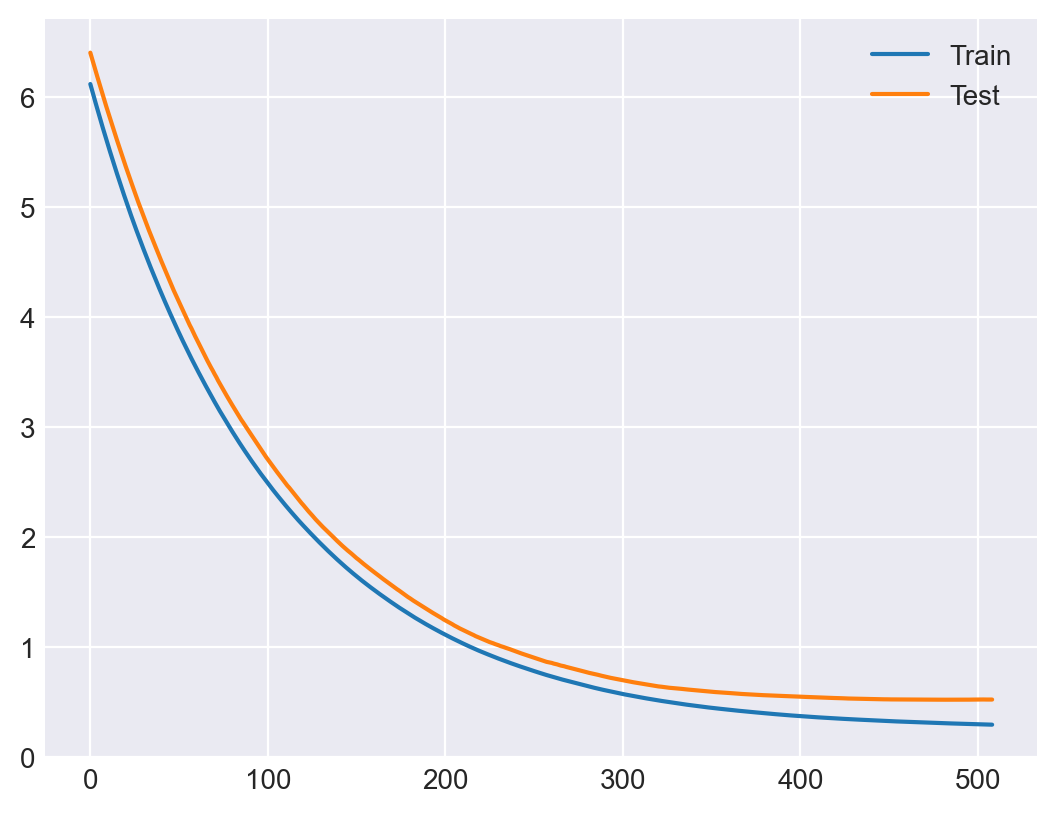

In [17]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

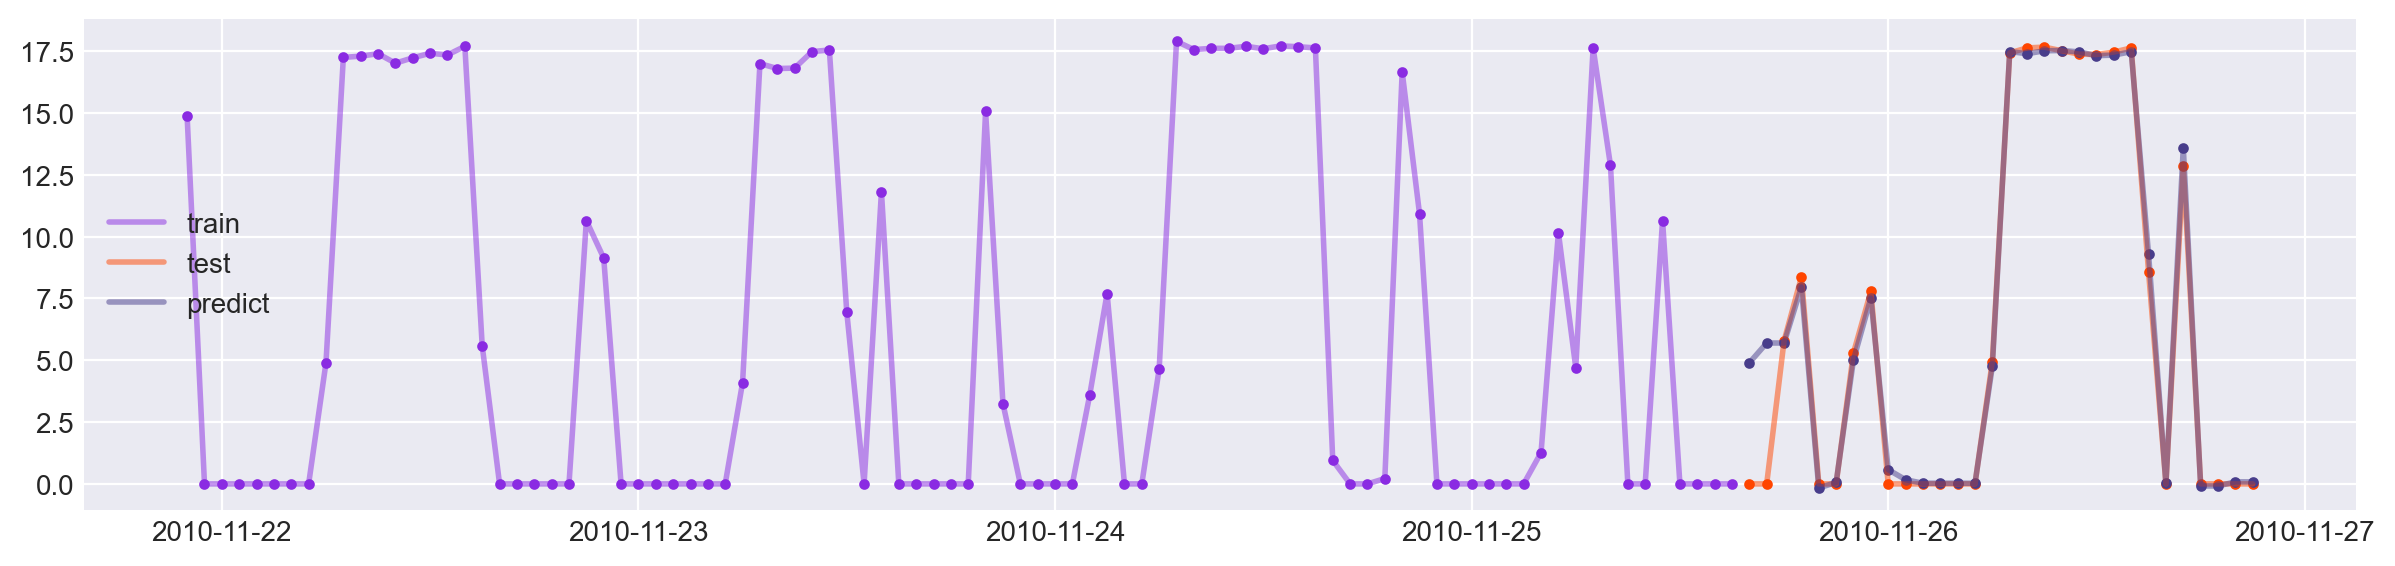

In [18]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [19]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 6.00555	training's l2: 44.2317	valid_1's l1: 6.0665	valid_1's l2: 45.7691
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 5.44816	training's l2: 36.4338	valid_1's l1: 5.52966	valid_1's l2: 37.9369
[3]	training's l1: 4.94835	training's l2: 30.049	valid_1's l1: 5.01868	valid_1's l2: 31.337
[4]	training's l1: 4.49251	training's l2: 24.8017	valid_1's l1: 4.62533	valid_1's l2: 26.4812
[5]	training's l1: 4.08178	training's l2: 20.487	valid_1's l1: 4.21542	valid_1's l2: 21.8079
[6]	training's l1: 3.71615	training's l2: 17.0154	valid_1's l1: 3.86518	valid_1's l2: 18.3183
[7]	training's l1: 3.38523	training's l2: 14.1571	valid_1's l1: 3.56028	valid_1's l2: 15.5167
[8]	training's l1: 3.08339	training's l2: 11.7778	valid_1's l1: 3.26834	valid_1's l2: 13.0938
[9]	training's l1: 2.81236	training's l2: 9.84618	valid_1's l1: 3.00693	valid_1's l2: 11.0964
[10]	training's l1: 2.57324	training's l2: 8.28669	valid_1's l1: 2.75724	valid_1's l2: 9.45278


[90]	training's l1: 0.263294	training's l2: 0.173743	valid_1's l1: 0.537998	valid_1's l2: 1.9744
[91]	training's l1: 0.261278	training's l2: 0.171737	valid_1's l1: 0.537746	valid_1's l2: 1.97784
[92]	training's l1: 0.259673	training's l2: 0.169783	valid_1's l1: 0.534568	valid_1's l2: 1.97205
[93]	training's l1: 0.258029	training's l2: 0.167586	valid_1's l1: 0.534541	valid_1's l2: 1.975
[94]	training's l1: 0.256667	training's l2: 0.166126	valid_1's l1: 0.529713	valid_1's l2: 1.95842
[95]	training's l1: 0.255646	training's l2: 0.164654	valid_1's l1: 0.529722	valid_1's l2: 1.95904
[96]	training's l1: 0.25458	training's l2: 0.163329	valid_1's l1: 0.528734	valid_1's l2: 1.95756
[97]	training's l1: 0.253104	training's l2: 0.161294	valid_1's l1: 0.529247	valid_1's l2: 1.95715
[98]	training's l1: 0.251837	training's l2: 0.159813	valid_1's l1: 0.525976	valid_1's l2: 1.95256
[99]	training's l1: 0.250772	training's l2: 0.158474	valid_1's l1: 0.525892	valid_1's l2: 1.95251
[100]	training's l1: 0.2

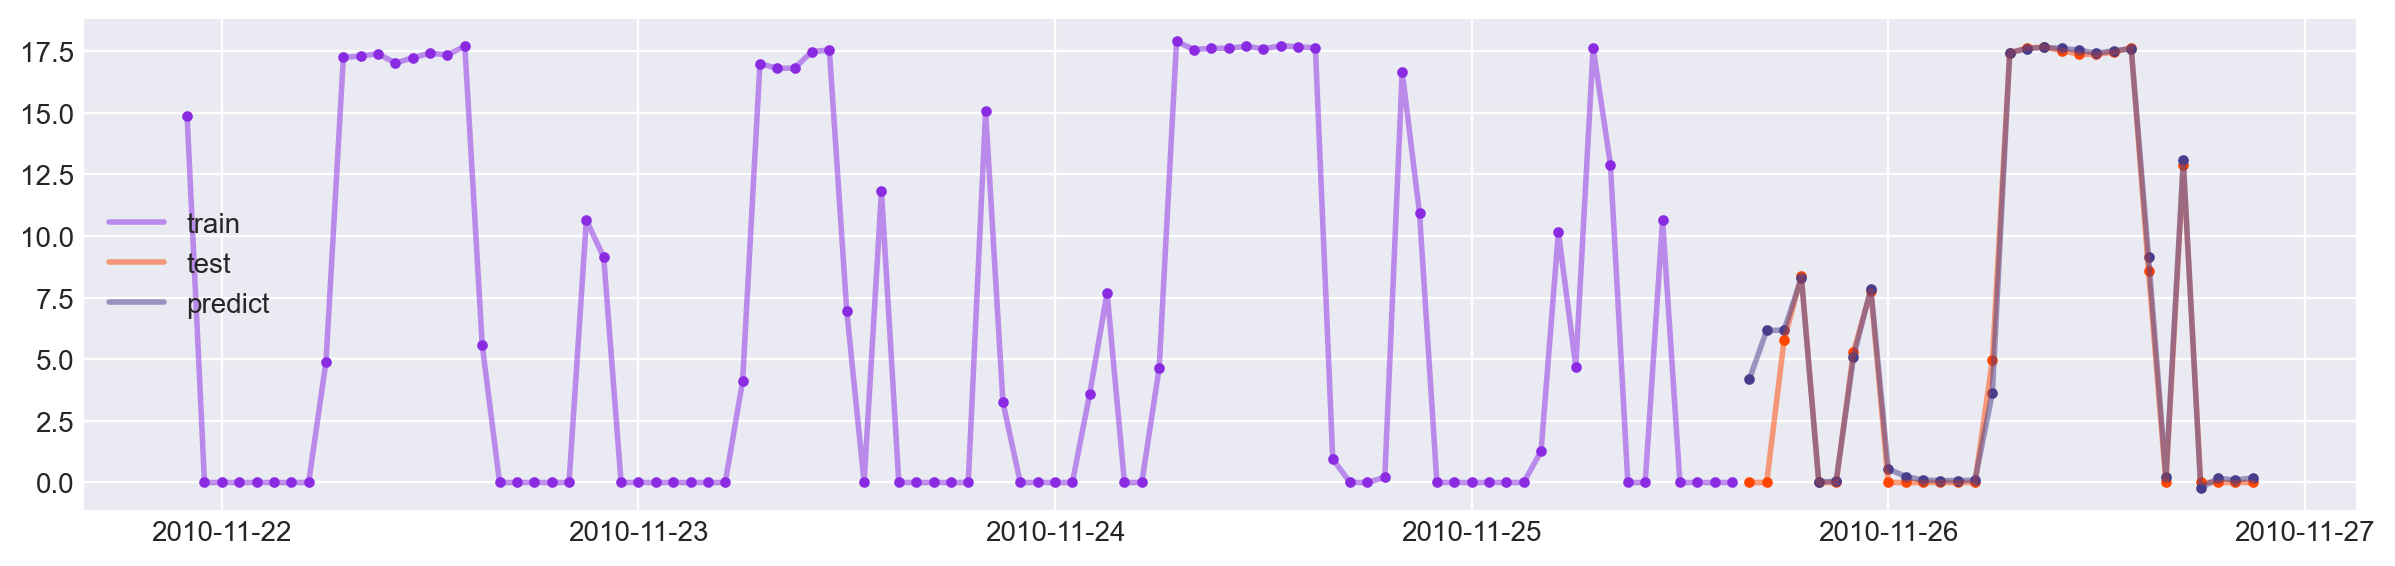

In [20]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [21]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[target_column].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 8.9034659	test: 9.0955972	best: 9.0955972 (0)	total: 142ms	remaining: 2m 21s
1:	learn: 8.1478082	test: 8.3588100	best: 8.3588100 (1)	total: 155ms	remaining: 1m 17s
2:	learn: 7.4939231	test: 7.7128888	best: 7.7128888 (2)	total: 193ms	remaining: 1m 4s
3:	learn: 6.8866548	test: 7.1094668	best: 7.1094668 (3)	total: 278ms	remaining: 1m 9s
4:	learn: 6.3369589	test: 6.5674817	best: 6.5674817 (4)	total: 355ms	remaining: 1m 10s
5:	learn: 5.8509710	test: 6.0864645	best: 6.0864645 (5)	total: 466ms	remaining: 1m 17s
6:	learn: 5.3876520	test: 5.6267853	best: 5.6267853 (6)	total: 540ms	remaining: 1m 16s
7:	learn: 4.9856504	test: 5.2315445	best: 5.2315445 (7)	total: 600ms	remaining: 1m 14s
8:	learn: 4.6300671	test: 4.8695794	best: 4.8695794 (8)	total: 618ms	remaining: 1m 8s
9:	learn: 4.3495050	test: 4.5865563	best: 4.5865563 (9)	total: 646ms	remaining: 1m 3s
10:	learn: 4.0750936	test: 4.3071838	best: 4.3071838 (10)	total: 679ms	remaining: 1m 1s
11:	learn: 3.8116293	test: 4.0388473	best: 4.0

95:	learn: 0.9038460	test: 0.9938171	best: 0.9938171 (95)	total: 5.04s	remaining: 47.4s
96:	learn: 0.8976083	test: 0.9865543	best: 0.9865543 (96)	total: 5.12s	remaining: 47.6s
97:	learn: 0.8904873	test: 0.9811209	best: 0.9811209 (97)	total: 5.18s	remaining: 47.7s
98:	learn: 0.8855545	test: 0.9788794	best: 0.9788794 (98)	total: 5.25s	remaining: 47.8s
99:	learn: 0.8783650	test: 0.9713981	best: 0.9713981 (99)	total: 5.3s	remaining: 47.8s
100:	learn: 0.8712533	test: 0.9649796	best: 0.9649796 (100)	total: 5.39s	remaining: 47.9s
101:	learn: 0.8670419	test: 0.9609124	best: 0.9609124 (101)	total: 5.43s	remaining: 47.8s
102:	learn: 0.8629851	test: 0.9555897	best: 0.9555897 (102)	total: 5.47s	remaining: 47.7s
103:	learn: 0.8556457	test: 0.9494250	best: 0.9494250 (103)	total: 5.48s	remaining: 47.2s
104:	learn: 0.8488951	test: 0.9436119	best: 0.9436119 (104)	total: 5.59s	remaining: 47.6s
105:	learn: 0.8442069	test: 0.9416974	best: 0.9416974 (105)	total: 5.65s	remaining: 47.7s
106:	learn: 0.8402724

192:	learn: 0.5606494	test: 0.6755490	best: 0.6755490 (192)	total: 10.3s	remaining: 43.1s
193:	learn: 0.5586794	test: 0.6729108	best: 0.6729108 (193)	total: 10.3s	remaining: 43s
194:	learn: 0.5570791	test: 0.6711125	best: 0.6711125 (194)	total: 10.4s	remaining: 43s
195:	learn: 0.5557840	test: 0.6699729	best: 0.6699729 (195)	total: 10.5s	remaining: 43.1s
196:	learn: 0.5544602	test: 0.6690751	best: 0.6690751 (196)	total: 10.5s	remaining: 43s
197:	learn: 0.5540420	test: 0.6685724	best: 0.6685724 (197)	total: 10.6s	remaining: 43s
198:	learn: 0.5529026	test: 0.6671527	best: 0.6671527 (198)	total: 10.6s	remaining: 42.8s
199:	learn: 0.5515310	test: 0.6660034	best: 0.6660034 (199)	total: 10.7s	remaining: 42.6s
200:	learn: 0.5505658	test: 0.6655881	best: 0.6655881 (200)	total: 10.7s	remaining: 42.5s
201:	learn: 0.5486950	test: 0.6634666	best: 0.6634666 (201)	total: 10.7s	remaining: 42.3s
202:	learn: 0.5472870	test: 0.6610227	best: 0.6610227 (202)	total: 10.7s	remaining: 42.2s
203:	learn: 0.5467

285:	learn: 0.4602568	test: 0.5766311	best: 0.5766311 (285)	total: 14.7s	remaining: 36.8s
286:	learn: 0.4594725	test: 0.5758125	best: 0.5758125 (286)	total: 14.8s	remaining: 36.8s
287:	learn: 0.4589478	test: 0.5752037	best: 0.5752037 (287)	total: 14.9s	remaining: 36.8s
288:	learn: 0.4584457	test: 0.5746114	best: 0.5746114 (288)	total: 14.9s	remaining: 36.8s
289:	learn: 0.4571071	test: 0.5731344	best: 0.5731344 (289)	total: 15s	remaining: 36.8s
290:	learn: 0.4559392	test: 0.5717190	best: 0.5717190 (290)	total: 15.1s	remaining: 36.7s
291:	learn: 0.4552636	test: 0.5704803	best: 0.5704803 (291)	total: 15.1s	remaining: 36.7s
292:	learn: 0.4545201	test: 0.5697024	best: 0.5697024 (292)	total: 15.2s	remaining: 36.6s
293:	learn: 0.4539835	test: 0.5690861	best: 0.5690861 (293)	total: 15.2s	remaining: 36.5s
294:	learn: 0.4527437	test: 0.5674413	best: 0.5674413 (294)	total: 15.2s	remaining: 36.4s
295:	learn: 0.4522218	test: 0.5670956	best: 0.5670956 (295)	total: 15.3s	remaining: 36.4s
296:	learn: 

381:	learn: 0.3929349	test: 0.5044898	best: 0.5044898 (381)	total: 19.4s	remaining: 31.3s
382:	learn: 0.3924201	test: 0.5037890	best: 0.5037890 (382)	total: 19.4s	remaining: 31.2s
383:	learn: 0.3915562	test: 0.5025921	best: 0.5025921 (383)	total: 19.4s	remaining: 31.1s
384:	learn: 0.3912344	test: 0.5019473	best: 0.5019473 (384)	total: 19.4s	remaining: 31.1s
385:	learn: 0.3907562	test: 0.5016941	best: 0.5016941 (385)	total: 19.5s	remaining: 31.1s
386:	learn: 0.3905728	test: 0.5011584	best: 0.5011584 (386)	total: 19.6s	remaining: 31s
387:	learn: 0.3902315	test: 0.5007918	best: 0.5007918 (387)	total: 19.6s	remaining: 30.9s
388:	learn: 0.3894753	test: 0.4997919	best: 0.4997919 (388)	total: 19.6s	remaining: 30.7s
389:	learn: 0.3890077	test: 0.4993288	best: 0.4993288 (389)	total: 19.6s	remaining: 30.6s
390:	learn: 0.3884796	test: 0.4987975	best: 0.4987975 (390)	total: 19.6s	remaining: 30.6s
391:	learn: 0.3877811	test: 0.4982858	best: 0.4982858 (391)	total: 19.7s	remaining: 30.5s
392:	learn: 

473:	learn: 0.3494439	test: 0.4571448	best: 0.4571448 (473)	total: 24.1s	remaining: 26.8s
474:	learn: 0.3491348	test: 0.4570042	best: 0.4570042 (474)	total: 24.1s	remaining: 26.7s
475:	learn: 0.3488603	test: 0.4563978	best: 0.4563978 (475)	total: 24.1s	remaining: 26.6s
476:	learn: 0.3485702	test: 0.4560580	best: 0.4560580 (476)	total: 24.1s	remaining: 26.5s
477:	learn: 0.3483282	test: 0.4559667	best: 0.4559667 (477)	total: 24.2s	remaining: 26.4s
478:	learn: 0.3476683	test: 0.4552676	best: 0.4552676 (478)	total: 24.2s	remaining: 26.4s
479:	learn: 0.3473455	test: 0.4549558	best: 0.4549558 (479)	total: 24.3s	remaining: 26.3s
480:	learn: 0.3471020	test: 0.4548250	best: 0.4548250 (480)	total: 24.4s	remaining: 26.3s
481:	learn: 0.3468867	test: 0.4543688	best: 0.4543688 (481)	total: 24.4s	remaining: 26.3s
482:	learn: 0.3466981	test: 0.4540568	best: 0.4540568 (482)	total: 24.5s	remaining: 26.2s
483:	learn: 0.3465871	test: 0.4536119	best: 0.4536119 (483)	total: 24.5s	remaining: 26.2s
484:	learn

568:	learn: 0.3146781	test: 0.4216186	best: 0.4216186 (568)	total: 28.6s	remaining: 21.6s
569:	learn: 0.3144475	test: 0.4212432	best: 0.4212432 (569)	total: 28.6s	remaining: 21.5s
570:	learn: 0.3143317	test: 0.4211506	best: 0.4211506 (570)	total: 28.6s	remaining: 21.5s
571:	learn: 0.3139197	test: 0.4205077	best: 0.4205077 (571)	total: 28.7s	remaining: 21.5s
572:	learn: 0.3136050	test: 0.4199502	best: 0.4199502 (572)	total: 28.7s	remaining: 21.4s
573:	learn: 0.3133507	test: 0.4198747	best: 0.4198747 (573)	total: 28.8s	remaining: 21.4s
574:	learn: 0.3131557	test: 0.4193560	best: 0.4193560 (574)	total: 28.9s	remaining: 21.3s
575:	learn: 0.3129732	test: 0.4190753	best: 0.4190753 (575)	total: 28.9s	remaining: 21.3s
576:	learn: 0.3126449	test: 0.4188027	best: 0.4188027 (576)	total: 28.9s	remaining: 21.2s
577:	learn: 0.3122330	test: 0.4182107	best: 0.4182107 (577)	total: 29s	remaining: 21.2s
578:	learn: 0.3119226	test: 0.4176879	best: 0.4176879 (578)	total: 29.1s	remaining: 21.1s
579:	learn: 

662:	learn: 0.2900806	test: 0.3947376	best: 0.3947376 (662)	total: 33.1s	remaining: 16.8s
663:	learn: 0.2898552	test: 0.3944432	best: 0.3944432 (663)	total: 33.2s	remaining: 16.8s
664:	learn: 0.2894989	test: 0.3939794	best: 0.3939794 (664)	total: 33.2s	remaining: 16.7s
665:	learn: 0.2893746	test: 0.3939648	best: 0.3939648 (665)	total: 33.3s	remaining: 16.7s
666:	learn: 0.2891315	test: 0.3939444	best: 0.3939444 (666)	total: 33.3s	remaining: 16.6s
667:	learn: 0.2889349	test: 0.3937363	best: 0.3937363 (667)	total: 33.3s	remaining: 16.6s
668:	learn: 0.2885941	test: 0.3932771	best: 0.3932771 (668)	total: 33.4s	remaining: 16.5s
669:	learn: 0.2884218	test: 0.3933435	best: 0.3932771 (668)	total: 33.5s	remaining: 16.5s
670:	learn: 0.2882188	test: 0.3931464	best: 0.3931464 (670)	total: 33.5s	remaining: 16.4s
671:	learn: 0.2881492	test: 0.3928653	best: 0.3928653 (671)	total: 33.5s	remaining: 16.4s
672:	learn: 0.2880514	test: 0.3928291	best: 0.3928291 (672)	total: 33.5s	remaining: 16.3s
673:	learn

757:	learn: 0.2701477	test: 0.3756321	best: 0.3756321 (757)	total: 37.8s	remaining: 12.1s
758:	learn: 0.2700974	test: 0.3753886	best: 0.3753886 (758)	total: 37.8s	remaining: 12s
759:	learn: 0.2699969	test: 0.3753626	best: 0.3753626 (759)	total: 37.9s	remaining: 12s
760:	learn: 0.2698737	test: 0.3753118	best: 0.3753118 (760)	total: 37.9s	remaining: 11.9s
761:	learn: 0.2698256	test: 0.3750691	best: 0.3750691 (761)	total: 38s	remaining: 11.9s
762:	learn: 0.2697058	test: 0.3748470	best: 0.3748470 (762)	total: 38.1s	remaining: 11.8s
763:	learn: 0.2693950	test: 0.3745405	best: 0.3745405 (763)	total: 38.1s	remaining: 11.8s
764:	learn: 0.2693275	test: 0.3745373	best: 0.3745373 (764)	total: 38.1s	remaining: 11.7s
765:	learn: 0.2692180	test: 0.3743433	best: 0.3743433 (765)	total: 38.2s	remaining: 11.7s
766:	learn: 0.2690830	test: 0.3743023	best: 0.3743023 (766)	total: 38.3s	remaining: 11.6s
767:	learn: 0.2688778	test: 0.3739107	best: 0.3739107 (767)	total: 38.3s	remaining: 11.6s
768:	learn: 0.26

851:	learn: 0.2555989	test: 0.3607091	best: 0.3607091 (851)	total: 42.5s	remaining: 7.38s
852:	learn: 0.2555078	test: 0.3606484	best: 0.3606484 (852)	total: 42.5s	remaining: 7.33s
853:	learn: 0.2553424	test: 0.3603355	best: 0.3603355 (853)	total: 42.5s	remaining: 7.27s
854:	learn: 0.2552657	test: 0.3601696	best: 0.3601696 (854)	total: 42.5s	remaining: 7.21s
855:	learn: 0.2551696	test: 0.3601385	best: 0.3601385 (855)	total: 42.5s	remaining: 7.16s
856:	learn: 0.2549682	test: 0.3598605	best: 0.3598605 (856)	total: 42.6s	remaining: 7.1s
857:	learn: 0.2548458	test: 0.3598188	best: 0.3598188 (857)	total: 42.6s	remaining: 7.05s
858:	learn: 0.2546462	test: 0.3596431	best: 0.3596431 (858)	total: 42.6s	remaining: 6.99s
859:	learn: 0.2545505	test: 0.3596993	best: 0.3596431 (858)	total: 42.6s	remaining: 6.94s
860:	learn: 0.2543149	test: 0.3593665	best: 0.3593665 (860)	total: 42.7s	remaining: 6.89s
861:	learn: 0.2542319	test: 0.3591869	best: 0.3591869 (861)	total: 42.7s	remaining: 6.84s
862:	learn:

943:	learn: 0.2433677	test: 0.3484097	best: 0.3484097 (943)	total: 46.5s	remaining: 2.76s
944:	learn: 0.2431548	test: 0.3481680	best: 0.3481680 (944)	total: 46.5s	remaining: 2.71s
945:	learn: 0.2430244	test: 0.3480827	best: 0.3480827 (945)	total: 46.5s	remaining: 2.66s
946:	learn: 0.2429384	test: 0.3480229	best: 0.3480229 (946)	total: 46.6s	remaining: 2.6s
947:	learn: 0.2427420	test: 0.3478721	best: 0.3478721 (947)	total: 46.6s	remaining: 2.56s
948:	learn: 0.2426043	test: 0.3476633	best: 0.3476633 (948)	total: 46.6s	remaining: 2.51s
949:	learn: 0.2424636	test: 0.3473921	best: 0.3473921 (949)	total: 46.7s	remaining: 2.46s
950:	learn: 0.2423626	test: 0.3473172	best: 0.3473172 (950)	total: 46.7s	remaining: 2.41s
951:	learn: 0.2422814	test: 0.3472952	best: 0.3472952 (951)	total: 46.8s	remaining: 2.36s
952:	learn: 0.2422241	test: 0.3471535	best: 0.3471535 (952)	total: 46.9s	remaining: 2.31s
953:	learn: 0.2421496	test: 0.3471609	best: 0.3471535 (952)	total: 46.9s	remaining: 2.26s
954:	learn:

39:	learn: 1.6354501	test: 1.6792516	best: 1.6792516 (39)	total: 1.99s	remaining: 47.8s
40:	learn: 1.6078717	test: 1.6528236	best: 1.6528236 (40)	total: 2.05s	remaining: 48s
41:	learn: 1.5832961	test: 1.6262007	best: 1.6262007 (41)	total: 2.08s	remaining: 47.6s
42:	learn: 1.5687948	test: 1.6090685	best: 1.6090685 (42)	total: 2.15s	remaining: 47.8s
43:	learn: 1.5452240	test: 1.5831688	best: 1.5831688 (43)	total: 2.21s	remaining: 48s
44:	learn: 1.5271922	test: 1.5626350	best: 1.5626350 (44)	total: 2.25s	remaining: 47.6s
45:	learn: 1.5109541	test: 1.5447896	best: 1.5447896 (45)	total: 2.35s	remaining: 48.7s
46:	learn: 1.4907013	test: 1.5286746	best: 1.5286746 (46)	total: 2.39s	remaining: 48.5s
47:	learn: 1.4656975	test: 1.5059828	best: 1.5059828 (47)	total: 2.5s	remaining: 49.5s
48:	learn: 1.4484107	test: 1.4896117	best: 1.4896117 (48)	total: 2.53s	remaining: 49.1s
49:	learn: 1.4354449	test: 1.4786135	best: 1.4786135 (49)	total: 2.56s	remaining: 48.7s
50:	learn: 1.4230979	test: 1.4679990	

135:	learn: 0.7177239	test: 0.8249071	best: 0.8249071 (135)	total: 7.37s	remaining: 46.8s
136:	learn: 0.7131170	test: 0.8190824	best: 0.8190824 (136)	total: 7.38s	remaining: 46.5s
137:	learn: 0.7085267	test: 0.8149839	best: 0.8149839 (137)	total: 7.48s	remaining: 46.7s
138:	learn: 0.7057650	test: 0.8141414	best: 0.8141414 (138)	total: 7.52s	remaining: 46.6s
139:	learn: 0.7021649	test: 0.8100528	best: 0.8100528 (139)	total: 7.62s	remaining: 46.8s
140:	learn: 0.6979663	test: 0.8034816	best: 0.8034816 (140)	total: 7.64s	remaining: 46.5s
141:	learn: 0.6937991	test: 0.8005578	best: 0.8005578 (141)	total: 7.66s	remaining: 46.3s
142:	learn: 0.6906948	test: 0.7979913	best: 0.7979913 (142)	total: 7.7s	remaining: 46.1s
143:	learn: 0.6891180	test: 0.7964085	best: 0.7964085 (143)	total: 7.73s	remaining: 46s
144:	learn: 0.6850903	test: 0.7906254	best: 0.7906254 (144)	total: 7.77s	remaining: 45.8s
145:	learn: 0.6811541	test: 0.7868935	best: 0.7868935 (145)	total: 7.81s	remaining: 45.7s
146:	learn: 0

229:	learn: 0.5249890	test: 0.6379533	best: 0.6379533 (229)	total: 12.4s	remaining: 41.5s
230:	learn: 0.5235065	test: 0.6363862	best: 0.6363862 (230)	total: 12.5s	remaining: 41.5s
231:	learn: 0.5227795	test: 0.6353170	best: 0.6353170 (231)	total: 12.5s	remaining: 41.5s
232:	learn: 0.5218207	test: 0.6344251	best: 0.6344251 (232)	total: 12.7s	remaining: 41.8s
233:	learn: 0.5208511	test: 0.6334641	best: 0.6334641 (233)	total: 12.8s	remaining: 41.8s
234:	learn: 0.5193629	test: 0.6318140	best: 0.6318140 (234)	total: 12.9s	remaining: 41.9s
235:	learn: 0.5183820	test: 0.6312759	best: 0.6312759 (235)	total: 12.9s	remaining: 41.9s
236:	learn: 0.5172221	test: 0.6298043	best: 0.6298043 (236)	total: 13s	remaining: 42s
237:	learn: 0.5163853	test: 0.6292731	best: 0.6292731 (237)	total: 13.1s	remaining: 41.9s
238:	learn: 0.5153115	test: 0.6275900	best: 0.6275900 (238)	total: 13.1s	remaining: 41.8s
239:	learn: 0.5149763	test: 0.6274542	best: 0.6274542 (239)	total: 13.2s	remaining: 41.6s
240:	learn: 0.

322:	learn: 0.4379595	test: 0.5489538	best: 0.5489538 (322)	total: 17.3s	remaining: 36.2s
323:	learn: 0.4375215	test: 0.5483188	best: 0.5483188 (323)	total: 17.3s	remaining: 36.1s
324:	learn: 0.4367877	test: 0.5478759	best: 0.5478759 (324)	total: 17.4s	remaining: 36.1s
325:	learn: 0.4361659	test: 0.5473254	best: 0.5473254 (325)	total: 17.5s	remaining: 36.1s
326:	learn: 0.4354876	test: 0.5468369	best: 0.5468369 (326)	total: 17.5s	remaining: 36.1s
327:	learn: 0.4344625	test: 0.5458741	best: 0.5458741 (327)	total: 17.6s	remaining: 36s
328:	learn: 0.4333240	test: 0.5444307	best: 0.5444307 (328)	total: 17.6s	remaining: 36s
329:	learn: 0.4326407	test: 0.5441588	best: 0.5441588 (329)	total: 17.7s	remaining: 35.9s
330:	learn: 0.4315178	test: 0.5427975	best: 0.5427975 (330)	total: 17.7s	remaining: 35.8s
331:	learn: 0.4311770	test: 0.5424943	best: 0.5424943 (331)	total: 17.8s	remaining: 35.8s
332:	learn: 0.4306113	test: 0.5419874	best: 0.5419874 (332)	total: 17.9s	remaining: 35.9s
333:	learn: 0.

415:	learn: 0.3815822	test: 0.4930926	best: 0.4930926 (415)	total: 23s	remaining: 32.3s
416:	learn: 0.3814319	test: 0.4929301	best: 0.4929301 (416)	total: 23.1s	remaining: 32.3s
417:	learn: 0.3810278	test: 0.4925017	best: 0.4925017 (417)	total: 23.3s	remaining: 32.4s
418:	learn: 0.3804908	test: 0.4918511	best: 0.4918511 (418)	total: 23.3s	remaining: 32.3s
419:	learn: 0.3802199	test: 0.4917184	best: 0.4917184 (419)	total: 23.3s	remaining: 32.2s
420:	learn: 0.3797354	test: 0.4910807	best: 0.4910807 (420)	total: 23.4s	remaining: 32.2s
421:	learn: 0.3790598	test: 0.4906227	best: 0.4906227 (421)	total: 23.4s	remaining: 32.1s
422:	learn: 0.3782378	test: 0.4894837	best: 0.4894837 (422)	total: 23.5s	remaining: 32s
423:	learn: 0.3775220	test: 0.4884409	best: 0.4884409 (423)	total: 23.5s	remaining: 31.9s
424:	learn: 0.3772327	test: 0.4879688	best: 0.4879688 (424)	total: 23.5s	remaining: 31.8s
425:	learn: 0.3770363	test: 0.4878439	best: 0.4878439 (425)	total: 23.6s	remaining: 31.8s
426:	learn: 0.

509:	learn: 0.3408360	test: 0.4499023	best: 0.4499023 (509)	total: 28.7s	remaining: 27.5s
510:	learn: 0.3405200	test: 0.4499629	best: 0.4499023 (509)	total: 28.7s	remaining: 27.4s
511:	learn: 0.3399590	test: 0.4497955	best: 0.4497955 (511)	total: 28.7s	remaining: 27.3s
512:	learn: 0.3394208	test: 0.4492515	best: 0.4492515 (512)	total: 28.8s	remaining: 27.3s
513:	learn: 0.3392420	test: 0.4487916	best: 0.4487916 (513)	total: 28.8s	remaining: 27.3s
514:	learn: 0.3387294	test: 0.4485196	best: 0.4485196 (514)	total: 28.9s	remaining: 27.2s
515:	learn: 0.3380636	test: 0.4475257	best: 0.4475257 (515)	total: 29s	remaining: 27.2s
516:	learn: 0.3377904	test: 0.4472720	best: 0.4472720 (516)	total: 29s	remaining: 27.1s
517:	learn: 0.3374685	test: 0.4469247	best: 0.4469247 (517)	total: 29.1s	remaining: 27.1s
518:	learn: 0.3373275	test: 0.4469481	best: 0.4469247 (517)	total: 29.1s	remaining: 27s
519:	learn: 0.3370746	test: 0.4465999	best: 0.4465999 (519)	total: 29.1s	remaining: 26.9s
520:	learn: 0.33

601:	learn: 0.3108863	test: 0.4192125	best: 0.4192125 (601)	total: 32.9s	remaining: 21.7s
602:	learn: 0.3104016	test: 0.4187539	best: 0.4187539 (602)	total: 32.9s	remaining: 21.7s
603:	learn: 0.3102172	test: 0.4186205	best: 0.4186205 (603)	total: 33s	remaining: 21.6s
604:	learn: 0.3100555	test: 0.4183083	best: 0.4183083 (604)	total: 33s	remaining: 21.6s
605:	learn: 0.3099101	test: 0.4182946	best: 0.4182946 (605)	total: 33.1s	remaining: 21.5s
606:	learn: 0.3096588	test: 0.4179034	best: 0.4179034 (606)	total: 33.2s	remaining: 21.5s
607:	learn: 0.3094861	test: 0.4176231	best: 0.4176231 (607)	total: 33.2s	remaining: 21.4s
608:	learn: 0.3091784	test: 0.4174573	best: 0.4174573 (608)	total: 33.2s	remaining: 21.3s
609:	learn: 0.3086681	test: 0.4169943	best: 0.4169943 (609)	total: 33.3s	remaining: 21.3s
610:	learn: 0.3082849	test: 0.4165793	best: 0.4165793 (610)	total: 33.4s	remaining: 21.2s
611:	learn: 0.3078551	test: 0.4159164	best: 0.4159164 (611)	total: 33.4s	remaining: 21.2s
612:	learn: 0.

693:	learn: 0.2867419	test: 0.3948427	best: 0.3948427 (693)	total: 37.5s	remaining: 16.5s
694:	learn: 0.2864500	test: 0.3945945	best: 0.3945945 (694)	total: 37.5s	remaining: 16.4s
695:	learn: 0.2862195	test: 0.3945252	best: 0.3945252 (695)	total: 37.5s	remaining: 16.4s
696:	learn: 0.2860861	test: 0.3943591	best: 0.3943591 (696)	total: 37.5s	remaining: 16.3s
697:	learn: 0.2857905	test: 0.3941717	best: 0.3941717 (697)	total: 37.6s	remaining: 16.3s
698:	learn: 0.2856828	test: 0.3941444	best: 0.3941444 (698)	total: 37.6s	remaining: 16.2s
699:	learn: 0.2855482	test: 0.3940085	best: 0.3940085 (699)	total: 37.6s	remaining: 16.1s
700:	learn: 0.2851765	test: 0.3938073	best: 0.3938073 (700)	total: 37.7s	remaining: 16.1s
701:	learn: 0.2849959	test: 0.3936660	best: 0.3936660 (701)	total: 37.8s	remaining: 16s
702:	learn: 0.2848644	test: 0.3934598	best: 0.3934598 (702)	total: 37.8s	remaining: 16s
703:	learn: 0.2846250	test: 0.3930991	best: 0.3930991 (703)	total: 37.9s	remaining: 15.9s
704:	learn: 0.

786:	learn: 0.2690772	test: 0.3778589	best: 0.3778589 (786)	total: 42.3s	remaining: 11.4s
787:	learn: 0.2688672	test: 0.3777196	best: 0.3777196 (787)	total: 42.3s	remaining: 11.4s
788:	learn: 0.2687387	test: 0.3775090	best: 0.3775090 (788)	total: 42.4s	remaining: 11.3s
789:	learn: 0.2685934	test: 0.3773279	best: 0.3773279 (789)	total: 42.4s	remaining: 11.3s
790:	learn: 0.2683359	test: 0.3769193	best: 0.3769193 (790)	total: 42.5s	remaining: 11.2s
791:	learn: 0.2682520	test: 0.3769198	best: 0.3769193 (790)	total: 42.5s	remaining: 11.2s
792:	learn: 0.2679876	test: 0.3768738	best: 0.3768738 (792)	total: 42.6s	remaining: 11.1s
793:	learn: 0.2678834	test: 0.3766243	best: 0.3766243 (793)	total: 42.6s	remaining: 11.1s
794:	learn: 0.2677303	test: 0.3765823	best: 0.3765823 (794)	total: 42.7s	remaining: 11s
795:	learn: 0.2676088	test: 0.3764351	best: 0.3764351 (795)	total: 42.7s	remaining: 11s
796:	learn: 0.2675004	test: 0.3763786	best: 0.3763786 (796)	total: 42.8s	remaining: 10.9s
797:	learn: 0.

882:	learn: 0.2537893	test: 0.3616322	best: 0.3616322 (882)	total: 47.1s	remaining: 6.25s
883:	learn: 0.2537113	test: 0.3615029	best: 0.3615029 (883)	total: 47.2s	remaining: 6.19s
884:	learn: 0.2535609	test: 0.3612935	best: 0.3612935 (884)	total: 47.2s	remaining: 6.13s
885:	learn: 0.2534533	test: 0.3612142	best: 0.3612142 (885)	total: 47.2s	remaining: 6.08s
886:	learn: 0.2532546	test: 0.3609911	best: 0.3609911 (886)	total: 47.3s	remaining: 6.02s
887:	learn: 0.2531832	test: 0.3609470	best: 0.3609470 (887)	total: 47.3s	remaining: 5.97s
888:	learn: 0.2530027	test: 0.3608169	best: 0.3608169 (888)	total: 47.4s	remaining: 5.91s
889:	learn: 0.2528161	test: 0.3606825	best: 0.3606825 (889)	total: 47.4s	remaining: 5.85s
890:	learn: 0.2527538	test: 0.3605246	best: 0.3605246 (890)	total: 47.4s	remaining: 5.8s
891:	learn: 0.2525096	test: 0.3602864	best: 0.3602864 (891)	total: 47.4s	remaining: 5.74s
892:	learn: 0.2523427	test: 0.3601815	best: 0.3601815 (892)	total: 47.4s	remaining: 5.68s
893:	learn:

977:	learn: 0.2417241	test: 0.3479823	best: 0.3479823 (977)	total: 51.9s	remaining: 1.17s
978:	learn: 0.2416304	test: 0.3478535	best: 0.3478535 (978)	total: 52s	remaining: 1.11s
979:	learn: 0.2414585	test: 0.3477262	best: 0.3477262 (979)	total: 52.1s	remaining: 1.06s
980:	learn: 0.2413634	test: 0.3477138	best: 0.3477138 (980)	total: 52.1s	remaining: 1.01s
981:	learn: 0.2412929	test: 0.3476770	best: 0.3476770 (981)	total: 52.1s	remaining: 955ms
982:	learn: 0.2411441	test: 0.3476528	best: 0.3476528 (982)	total: 52.1s	remaining: 902ms
983:	learn: 0.2409901	test: 0.3474555	best: 0.3474555 (983)	total: 52.2s	remaining: 848ms
984:	learn: 0.2408499	test: 0.3472433	best: 0.3472433 (984)	total: 52.2s	remaining: 795ms
985:	learn: 0.2406175	test: 0.3471253	best: 0.3471253 (985)	total: 52.2s	remaining: 741ms
986:	learn: 0.2404945	test: 0.3469728	best: 0.3469728 (986)	total: 52.2s	remaining: 688ms
987:	learn: 0.2404317	test: 0.3469479	best: 0.3469479 (987)	total: 52.3s	remaining: 635ms
988:	learn: 

71:	learn: 1.1803909	test: 1.3275182	best: 1.3275182 (71)	total: 2.66s	remaining: 34.3s
72:	learn: 1.1620956	test: 1.3110422	best: 1.3110422 (72)	total: 2.74s	remaining: 34.8s
73:	learn: 1.1528056	test: 1.2983714	best: 1.2983714 (73)	total: 2.79s	remaining: 34.9s
74:	learn: 1.1377759	test: 1.2825418	best: 1.2825418 (74)	total: 2.84s	remaining: 35s
75:	learn: 1.1278682	test: 1.2682018	best: 1.2682018 (75)	total: 2.94s	remaining: 35.7s
76:	learn: 1.1138425	test: 1.2551234	best: 1.2551234 (76)	total: 2.99s	remaining: 35.8s
77:	learn: 1.1009364	test: 1.2401304	best: 1.2401304 (77)	total: 3.05s	remaining: 36.1s
78:	learn: 1.0907038	test: 1.2301799	best: 1.2301799 (78)	total: 3.09s	remaining: 36s
79:	learn: 1.0839303	test: 1.2225446	best: 1.2225446 (79)	total: 3.12s	remaining: 35.9s
80:	learn: 1.0755432	test: 1.2162331	best: 1.2162331 (80)	total: 3.17s	remaining: 36s
81:	learn: 1.0638446	test: 1.2077437	best: 1.2077437 (81)	total: 3.18s	remaining: 35.6s
82:	learn: 1.0611649	test: 1.2039088	b

164:	learn: 0.6778781	test: 0.7590867	best: 0.7590867 (164)	total: 7.56s	remaining: 38.3s
165:	learn: 0.6741819	test: 0.7560960	best: 0.7560960 (165)	total: 7.57s	remaining: 38s
166:	learn: 0.6718738	test: 0.7526981	best: 0.7526981 (166)	total: 7.59s	remaining: 37.9s
167:	learn: 0.6709929	test: 0.7524658	best: 0.7524658 (167)	total: 7.67s	remaining: 38s
168:	learn: 0.6681988	test: 0.7487873	best: 0.7487873 (168)	total: 7.74s	remaining: 38.1s
169:	learn: 0.6657475	test: 0.7469930	best: 0.7469930 (169)	total: 7.78s	remaining: 38s
170:	learn: 0.6642808	test: 0.7408245	best: 0.7408245 (170)	total: 7.79s	remaining: 37.8s
171:	learn: 0.6621728	test: 0.7375721	best: 0.7375721 (171)	total: 7.89s	remaining: 38s
172:	learn: 0.6604550	test: 0.7362879	best: 0.7362879 (172)	total: 7.94s	remaining: 38s
173:	learn: 0.6593323	test: 0.7359736	best: 0.7359736 (173)	total: 7.96s	remaining: 37.8s
174:	learn: 0.6581878	test: 0.7339797	best: 0.7339797 (174)	total: 8.01s	remaining: 37.8s
175:	learn: 0.656022

258:	learn: 0.5332784	test: 0.5954538	best: 0.5954538 (258)	total: 12.2s	remaining: 35s
259:	learn: 0.5318511	test: 0.5949013	best: 0.5949013 (259)	total: 12.2s	remaining: 34.8s
260:	learn: 0.5300960	test: 0.5925764	best: 0.5925764 (260)	total: 12.2s	remaining: 34.7s
261:	learn: 0.5287713	test: 0.5906352	best: 0.5906352 (261)	total: 12.3s	remaining: 34.5s
262:	learn: 0.5278754	test: 0.5898333	best: 0.5898333 (262)	total: 12.3s	remaining: 34.6s
263:	learn: 0.5270141	test: 0.5887434	best: 0.5887434 (263)	total: 12.4s	remaining: 34.6s
264:	learn: 0.5258935	test: 0.5871799	best: 0.5871799 (264)	total: 12.4s	remaining: 34.5s
265:	learn: 0.5254875	test: 0.5871552	best: 0.5871552 (265)	total: 12.4s	remaining: 34.4s
266:	learn: 0.5244255	test: 0.5852765	best: 0.5852765 (266)	total: 12.6s	remaining: 34.5s
267:	learn: 0.5229936	test: 0.5846176	best: 0.5846176 (267)	total: 12.6s	remaining: 34.4s
268:	learn: 0.5224868	test: 0.5843458	best: 0.5843458 (268)	total: 12.7s	remaining: 34.4s
269:	learn: 

352:	learn: 0.4505988	test: 0.5110849	best: 0.5110849 (352)	total: 16.6s	remaining: 30.4s
353:	learn: 0.4496157	test: 0.5103689	best: 0.5103689 (353)	total: 16.6s	remaining: 30.4s
354:	learn: 0.4488526	test: 0.5098427	best: 0.5098427 (354)	total: 16.7s	remaining: 30.3s
355:	learn: 0.4478739	test: 0.5082613	best: 0.5082613 (355)	total: 16.8s	remaining: 30.3s
356:	learn: 0.4467521	test: 0.5065285	best: 0.5065285 (356)	total: 16.8s	remaining: 30.2s
357:	learn: 0.4458061	test: 0.5059100	best: 0.5059100 (357)	total: 16.8s	remaining: 30.2s
358:	learn: 0.4450507	test: 0.5054396	best: 0.5054396 (358)	total: 16.9s	remaining: 30.1s
359:	learn: 0.4439784	test: 0.5041093	best: 0.5041093 (359)	total: 16.9s	remaining: 30.1s
360:	learn: 0.4431871	test: 0.5030484	best: 0.5030484 (360)	total: 17s	remaining: 30.1s
361:	learn: 0.4425121	test: 0.5022111	best: 0.5022111 (361)	total: 17s	remaining: 30s
362:	learn: 0.4414865	test: 0.5010550	best: 0.5010550 (362)	total: 17s	remaining: 29.9s
363:	learn: 0.4405

445:	learn: 0.3892007	test: 0.4471481	best: 0.4471481 (445)	total: 20.9s	remaining: 26s
446:	learn: 0.3883986	test: 0.4463980	best: 0.4463980 (446)	total: 20.9s	remaining: 25.9s
447:	learn: 0.3874749	test: 0.4456645	best: 0.4456645 (447)	total: 20.9s	remaining: 25.8s
448:	learn: 0.3870892	test: 0.4447600	best: 0.4447600 (448)	total: 21s	remaining: 25.7s
449:	learn: 0.3865713	test: 0.4441520	best: 0.4441520 (449)	total: 21s	remaining: 25.6s
450:	learn: 0.3859913	test: 0.4440242	best: 0.4440242 (450)	total: 21s	remaining: 25.6s
451:	learn: 0.3855075	test: 0.4437158	best: 0.4437158 (451)	total: 21.1s	remaining: 25.6s
452:	learn: 0.3848724	test: 0.4434961	best: 0.4434961 (452)	total: 21.1s	remaining: 25.5s
453:	learn: 0.3846721	test: 0.4434324	best: 0.4434324 (453)	total: 21.2s	remaining: 25.5s
454:	learn: 0.3843817	test: 0.4423538	best: 0.4423538 (454)	total: 21.3s	remaining: 25.5s
455:	learn: 0.3841468	test: 0.4420631	best: 0.4420631 (455)	total: 21.3s	remaining: 25.4s
456:	learn: 0.3839

540:	learn: 0.3497888	test: 0.4071684	best: 0.4071684 (540)	total: 24.8s	remaining: 21.1s
541:	learn: 0.3492290	test: 0.4068758	best: 0.4068758 (541)	total: 24.9s	remaining: 21s
542:	learn: 0.3489979	test: 0.4066164	best: 0.4066164 (542)	total: 24.9s	remaining: 20.9s
543:	learn: 0.3485219	test: 0.4063135	best: 0.4063135 (543)	total: 24.9s	remaining: 20.9s
544:	learn: 0.3479592	test: 0.4056765	best: 0.4056765 (544)	total: 24.9s	remaining: 20.8s
545:	learn: 0.3477032	test: 0.4052750	best: 0.4052750 (545)	total: 25s	remaining: 20.8s
546:	learn: 0.3472350	test: 0.4036956	best: 0.4036956 (546)	total: 25s	remaining: 20.7s
547:	learn: 0.3466295	test: 0.4030403	best: 0.4030403 (547)	total: 25.1s	remaining: 20.7s
548:	learn: 0.3461821	test: 0.4028198	best: 0.4028198 (548)	total: 25.2s	remaining: 20.7s
549:	learn: 0.3457025	test: 0.4028271	best: 0.4028198 (548)	total: 25.2s	remaining: 20.6s
550:	learn: 0.3454811	test: 0.4026828	best: 0.4026828 (550)	total: 25.3s	remaining: 20.6s
551:	learn: 0.34

636:	learn: 0.3176303	test: 0.3765167	best: 0.3765167 (636)	total: 29.8s	remaining: 17s
637:	learn: 0.3174167	test: 0.3764947	best: 0.3764947 (637)	total: 29.8s	remaining: 16.9s
638:	learn: 0.3173198	test: 0.3764800	best: 0.3764800 (638)	total: 29.8s	remaining: 16.8s
639:	learn: 0.3171963	test: 0.3761146	best: 0.3761146 (639)	total: 29.8s	remaining: 16.8s
640:	learn: 0.3170008	test: 0.3759255	best: 0.3759255 (640)	total: 29.8s	remaining: 16.7s
641:	learn: 0.3168486	test: 0.3758461	best: 0.3758461 (641)	total: 29.8s	remaining: 16.6s
642:	learn: 0.3164551	test: 0.3754377	best: 0.3754377 (642)	total: 29.9s	remaining: 16.6s
643:	learn: 0.3160456	test: 0.3751830	best: 0.3751830 (643)	total: 29.9s	remaining: 16.5s
644:	learn: 0.3156562	test: 0.3747476	best: 0.3747476 (644)	total: 30s	remaining: 16.5s
645:	learn: 0.3153486	test: 0.3744992	best: 0.3744992 (645)	total: 30s	remaining: 16.5s
646:	learn: 0.3152592	test: 0.3744582	best: 0.3744582 (646)	total: 30.1s	remaining: 16.4s
647:	learn: 0.31

734:	learn: 0.2943149	test: 0.3556187	best: 0.3556187 (734)	total: 34.1s	remaining: 12.3s
735:	learn: 0.2937803	test: 0.3551033	best: 0.3551033 (735)	total: 34.1s	remaining: 12.2s
736:	learn: 0.2936054	test: 0.3551026	best: 0.3551026 (736)	total: 34.2s	remaining: 12.2s
737:	learn: 0.2933462	test: 0.3546137	best: 0.3546137 (737)	total: 34.3s	remaining: 12.2s
738:	learn: 0.2931168	test: 0.3537828	best: 0.3537828 (738)	total: 34.3s	remaining: 12.1s
739:	learn: 0.2929893	test: 0.3535864	best: 0.3535864 (739)	total: 34.4s	remaining: 12.1s
740:	learn: 0.2927005	test: 0.3530906	best: 0.3530906 (740)	total: 34.5s	remaining: 12s
741:	learn: 0.2925716	test: 0.3529677	best: 0.3529677 (741)	total: 34.5s	remaining: 12s
742:	learn: 0.2924246	test: 0.3528811	best: 0.3528811 (742)	total: 34.5s	remaining: 11.9s
743:	learn: 0.2921832	test: 0.3527961	best: 0.3527961 (743)	total: 34.5s	remaining: 11.9s
744:	learn: 0.2920825	test: 0.3526672	best: 0.3526672 (744)	total: 34.6s	remaining: 11.9s
745:	learn: 0.

829:	learn: 0.2762589	test: 0.3386011	best: 0.3386011 (829)	total: 38.5s	remaining: 7.88s
830:	learn: 0.2761946	test: 0.3385869	best: 0.3385869 (830)	total: 38.5s	remaining: 7.82s
831:	learn: 0.2761108	test: 0.3385971	best: 0.3385869 (830)	total: 38.5s	remaining: 7.77s
832:	learn: 0.2758292	test: 0.3380578	best: 0.3380578 (832)	total: 38.5s	remaining: 7.72s
833:	learn: 0.2755957	test: 0.3381278	best: 0.3380578 (832)	total: 38.6s	remaining: 7.68s
834:	learn: 0.2753675	test: 0.3376161	best: 0.3376161 (834)	total: 38.6s	remaining: 7.63s
835:	learn: 0.2752505	test: 0.3374415	best: 0.3374415 (835)	total: 38.7s	remaining: 7.58s
836:	learn: 0.2750871	test: 0.3373376	best: 0.3373376 (836)	total: 38.7s	remaining: 7.53s
837:	learn: 0.2748621	test: 0.3372110	best: 0.3372110 (837)	total: 38.8s	remaining: 7.5s
838:	learn: 0.2744711	test: 0.3368290	best: 0.3368290 (838)	total: 38.9s	remaining: 7.46s
839:	learn: 0.2743422	test: 0.3367589	best: 0.3367589 (839)	total: 38.9s	remaining: 7.42s
840:	learn:

921:	learn: 0.2622713	test: 0.3248911	best: 0.3248911 (921)	total: 42.5s	remaining: 3.59s
922:	learn: 0.2621457	test: 0.3246897	best: 0.3246897 (922)	total: 42.5s	remaining: 3.55s
923:	learn: 0.2620262	test: 0.3246170	best: 0.3246170 (923)	total: 42.6s	remaining: 3.5s
924:	learn: 0.2619597	test: 0.3246310	best: 0.3246170 (923)	total: 42.6s	remaining: 3.45s
925:	learn: 0.2618167	test: 0.3246093	best: 0.3246093 (925)	total: 42.7s	remaining: 3.41s
926:	learn: 0.2617350	test: 0.3246035	best: 0.3246035 (926)	total: 42.8s	remaining: 3.37s
927:	learn: 0.2615761	test: 0.3245618	best: 0.3245618 (927)	total: 42.8s	remaining: 3.32s
928:	learn: 0.2615067	test: 0.3245772	best: 0.3245618 (927)	total: 42.9s	remaining: 3.27s
929:	learn: 0.2614400	test: 0.3246214	best: 0.3245618 (927)	total: 42.9s	remaining: 3.23s
930:	learn: 0.2612864	test: 0.3243338	best: 0.3243338 (930)	total: 43s	remaining: 3.19s
931:	learn: 0.2611043	test: 0.3239603	best: 0.3239603 (931)	total: 43s	remaining: 3.14s
932:	learn: 0.2

15:	learn: 3.1355439	test: 3.0980706	best: 3.0980706 (15)	total: 792ms	remaining: 48.7s
16:	learn: 2.9879531	test: 2.9524882	best: 2.9524882 (16)	total: 821ms	remaining: 47.5s
17:	learn: 2.8542092	test: 2.8255337	best: 2.8255337 (17)	total: 840ms	remaining: 45.8s
18:	learn: 2.7358055	test: 2.7092159	best: 2.7092159 (18)	total: 855ms	remaining: 44.1s
19:	learn: 2.6359563	test: 2.6087605	best: 2.6087605 (19)	total: 895ms	remaining: 43.9s
20:	learn: 2.5401838	test: 2.5153378	best: 2.5153378 (20)	total: 946ms	remaining: 44.1s
21:	learn: 2.4394757	test: 2.4182442	best: 2.4182442 (21)	total: 1.03s	remaining: 45.8s
22:	learn: 2.3620265	test: 2.3446397	best: 2.3446397 (22)	total: 1.04s	remaining: 44.2s
23:	learn: 2.2984965	test: 2.2826468	best: 2.2826468 (23)	total: 1.05s	remaining: 42.7s
24:	learn: 2.2039903	test: 2.1873170	best: 2.1873170 (24)	total: 1.07s	remaining: 41.7s
25:	learn: 2.1422264	test: 2.1264850	best: 2.1264850 (25)	total: 1.18s	remaining: 44.3s
26:	learn: 2.0972364	test: 2.084

112:	learn: 0.8549719	test: 0.8955038	best: 0.8955038 (112)	total: 5.72s	remaining: 44.9s
113:	learn: 0.8498674	test: 0.8902606	best: 0.8902606 (113)	total: 5.73s	remaining: 44.5s
114:	learn: 0.8435807	test: 0.8850540	best: 0.8850540 (114)	total: 5.74s	remaining: 44.2s
115:	learn: 0.8405804	test: 0.8824392	best: 0.8824392 (115)	total: 5.78s	remaining: 44s
116:	learn: 0.8347154	test: 0.8762462	best: 0.8762462 (116)	total: 5.83s	remaining: 44s
117:	learn: 0.8324303	test: 0.8748644	best: 0.8748644 (117)	total: 5.89s	remaining: 44.1s
118:	learn: 0.8289350	test: 0.8717096	best: 0.8717096 (118)	total: 5.94s	remaining: 44s
119:	learn: 0.8226489	test: 0.8662676	best: 0.8662676 (119)	total: 6.05s	remaining: 44.4s
120:	learn: 0.8162428	test: 0.8614806	best: 0.8614806 (120)	total: 6.1s	remaining: 44.3s
121:	learn: 0.8110488	test: 0.8564360	best: 0.8564360 (121)	total: 6.15s	remaining: 44.2s
122:	learn: 0.8063855	test: 0.8523362	best: 0.8523362 (122)	total: 6.17s	remaining: 44s
123:	learn: 0.80166

205:	learn: 0.5775906	test: 0.6541776	best: 0.6541776 (205)	total: 9.7s	remaining: 37.4s
206:	learn: 0.5761105	test: 0.6529483	best: 0.6529483 (206)	total: 9.8s	remaining: 37.5s
207:	learn: 0.5750450	test: 0.6522240	best: 0.6522240 (207)	total: 9.85s	remaining: 37.5s
208:	learn: 0.5739912	test: 0.6510278	best: 0.6510278 (208)	total: 9.89s	remaining: 37.4s
209:	learn: 0.5725865	test: 0.6495645	best: 0.6495645 (209)	total: 9.96s	remaining: 37.5s
210:	learn: 0.5706974	test: 0.6482343	best: 0.6482343 (210)	total: 10s	remaining: 37.4s
211:	learn: 0.5699630	test: 0.6474368	best: 0.6474368 (211)	total: 10.1s	remaining: 37.6s
212:	learn: 0.5678387	test: 0.6453606	best: 0.6453606 (212)	total: 10.2s	remaining: 37.5s
213:	learn: 0.5664315	test: 0.6440295	best: 0.6440295 (213)	total: 10.2s	remaining: 37.4s
214:	learn: 0.5653813	test: 0.6431229	best: 0.6431229 (214)	total: 10.3s	remaining: 37.5s
215:	learn: 0.5633862	test: 0.6414534	best: 0.6414534 (215)	total: 10.3s	remaining: 37.4s
216:	learn: 0.

299:	learn: 0.4693255	test: 0.5611295	best: 0.5611295 (299)	total: 14s	remaining: 32.6s
300:	learn: 0.4687898	test: 0.5606333	best: 0.5606333 (300)	total: 14s	remaining: 32.5s
301:	learn: 0.4680491	test: 0.5599440	best: 0.5599440 (301)	total: 14.1s	remaining: 32.5s
302:	learn: 0.4665755	test: 0.5591133	best: 0.5591133 (302)	total: 14.1s	remaining: 32.5s
303:	learn: 0.4659146	test: 0.5585412	best: 0.5585412 (303)	total: 14.2s	remaining: 32.5s
304:	learn: 0.4652810	test: 0.5581751	best: 0.5581751 (304)	total: 14.2s	remaining: 32.3s
305:	learn: 0.4648710	test: 0.5579821	best: 0.5579821 (305)	total: 14.2s	remaining: 32.2s
306:	learn: 0.4642535	test: 0.5574823	best: 0.5574823 (306)	total: 14.3s	remaining: 32.2s
307:	learn: 0.4639634	test: 0.5575412	best: 0.5574823 (306)	total: 14.3s	remaining: 32.2s
308:	learn: 0.4635141	test: 0.5567700	best: 0.5567700 (308)	total: 14.4s	remaining: 32.1s
309:	learn: 0.4623931	test: 0.5557393	best: 0.5557393 (309)	total: 14.4s	remaining: 32.1s
310:	learn: 0.

393:	learn: 0.4012271	test: 0.5053393	best: 0.5053393 (393)	total: 18.4s	remaining: 28.3s
394:	learn: 0.4009026	test: 0.5053780	best: 0.5053393 (393)	total: 18.4s	remaining: 28.2s
395:	learn: 0.3999994	test: 0.5047765	best: 0.5047765 (395)	total: 18.5s	remaining: 28.2s
396:	learn: 0.3995606	test: 0.5044107	best: 0.5044107 (396)	total: 18.5s	remaining: 28.2s
397:	learn: 0.3993080	test: 0.5043205	best: 0.5043205 (397)	total: 18.6s	remaining: 28.1s
398:	learn: 0.3987191	test: 0.5039013	best: 0.5039013 (398)	total: 18.6s	remaining: 28s
399:	learn: 0.3985287	test: 0.5038606	best: 0.5038606 (399)	total: 18.6s	remaining: 27.9s
400:	learn: 0.3976680	test: 0.5032014	best: 0.5032014 (400)	total: 18.6s	remaining: 27.8s
401:	learn: 0.3970601	test: 0.5030204	best: 0.5030204 (401)	total: 18.7s	remaining: 27.8s
402:	learn: 0.3964803	test: 0.5024953	best: 0.5024953 (402)	total: 18.7s	remaining: 27.8s
403:	learn: 0.3960059	test: 0.5020353	best: 0.5020353 (403)	total: 18.8s	remaining: 27.7s
404:	learn: 

487:	learn: 0.3573721	test: 0.4678914	best: 0.4678914 (487)	total: 23.2s	remaining: 24.3s
488:	learn: 0.3570940	test: 0.4680095	best: 0.4678914 (487)	total: 23.2s	remaining: 24.2s
489:	learn: 0.3568868	test: 0.4677959	best: 0.4677959 (489)	total: 23.3s	remaining: 24.2s
490:	learn: 0.3567235	test: 0.4676539	best: 0.4676539 (490)	total: 23.3s	remaining: 24.2s
491:	learn: 0.3564158	test: 0.4673003	best: 0.4673003 (491)	total: 23.4s	remaining: 24.2s
492:	learn: 0.3559734	test: 0.4671717	best: 0.4671717 (492)	total: 23.5s	remaining: 24.2s
493:	learn: 0.3557253	test: 0.4669820	best: 0.4669820 (493)	total: 23.5s	remaining: 24.1s
494:	learn: 0.3553947	test: 0.4667167	best: 0.4667167 (494)	total: 23.6s	remaining: 24.1s
495:	learn: 0.3547563	test: 0.4663551	best: 0.4663551 (495)	total: 23.6s	remaining: 24s
496:	learn: 0.3543761	test: 0.4660779	best: 0.4660779 (496)	total: 23.7s	remaining: 24s
497:	learn: 0.3541477	test: 0.4660793	best: 0.4660779 (496)	total: 23.8s	remaining: 24s
498:	learn: 0.35

584:	learn: 0.3257491	test: 0.4416194	best: 0.4416194 (584)	total: 27.9s	remaining: 19.8s
585:	learn: 0.3256499	test: 0.4415678	best: 0.4415678 (585)	total: 27.9s	remaining: 19.7s
586:	learn: 0.3252349	test: 0.4412935	best: 0.4412935 (586)	total: 28s	remaining: 19.7s
587:	learn: 0.3251405	test: 0.4412883	best: 0.4412883 (587)	total: 28s	remaining: 19.6s
588:	learn: 0.3249659	test: 0.4411420	best: 0.4411420 (588)	total: 28.1s	remaining: 19.6s
589:	learn: 0.3245077	test: 0.4407835	best: 0.4407835 (589)	total: 28.1s	remaining: 19.5s
590:	learn: 0.3243623	test: 0.4407941	best: 0.4407835 (589)	total: 28.2s	remaining: 19.5s
591:	learn: 0.3241386	test: 0.4406438	best: 0.4406438 (591)	total: 28.2s	remaining: 19.4s
592:	learn: 0.3237885	test: 0.4403669	best: 0.4403669 (592)	total: 28.2s	remaining: 19.4s
593:	learn: 0.3235497	test: 0.4401816	best: 0.4401816 (593)	total: 28.3s	remaining: 19.3s
594:	learn: 0.3229321	test: 0.4396052	best: 0.4396052 (594)	total: 28.4s	remaining: 19.3s
595:	learn: 0.

679:	learn: 0.3009931	test: 0.4218676	best: 0.4218676 (679)	total: 31.9s	remaining: 15s
680:	learn: 0.3006562	test: 0.4216038	best: 0.4216038 (680)	total: 32s	remaining: 15s
681:	learn: 0.3003727	test: 0.4212968	best: 0.4212968 (681)	total: 32s	remaining: 14.9s
682:	learn: 0.3001300	test: 0.4209774	best: 0.4209774 (682)	total: 32.1s	remaining: 14.9s
683:	learn: 0.2999573	test: 0.4209212	best: 0.4209212 (683)	total: 32.1s	remaining: 14.8s
684:	learn: 0.2997513	test: 0.4208495	best: 0.4208495 (684)	total: 32.3s	remaining: 14.8s
685:	learn: 0.2996298	test: 0.4201816	best: 0.4201816 (685)	total: 32.3s	remaining: 14.8s
686:	learn: 0.2994856	test: 0.4200889	best: 0.4200889 (686)	total: 32.4s	remaining: 14.8s
687:	learn: 0.2993320	test: 0.4200294	best: 0.4200294 (687)	total: 32.5s	remaining: 14.8s
688:	learn: 0.2991942	test: 0.4200854	best: 0.4200294 (687)	total: 32.5s	remaining: 14.7s
689:	learn: 0.2989397	test: 0.4199555	best: 0.4199555 (689)	total: 32.6s	remaining: 14.6s
690:	learn: 0.2986

771:	learn: 0.2829120	test: 0.4049201	best: 0.4049201 (771)	total: 36.8s	remaining: 10.9s
772:	learn: 0.2826942	test: 0.4046911	best: 0.4046911 (772)	total: 36.9s	remaining: 10.8s
773:	learn: 0.2826025	test: 0.4047560	best: 0.4046911 (772)	total: 36.9s	remaining: 10.8s
774:	learn: 0.2822925	test: 0.4044952	best: 0.4044952 (774)	total: 37s	remaining: 10.7s
775:	learn: 0.2821295	test: 0.4043942	best: 0.4043942 (775)	total: 37s	remaining: 10.7s
776:	learn: 0.2818386	test: 0.4042799	best: 0.4042799 (776)	total: 37s	remaining: 10.6s
777:	learn: 0.2817000	test: 0.4041528	best: 0.4041528 (777)	total: 37.1s	remaining: 10.6s
778:	learn: 0.2813898	test: 0.4038822	best: 0.4038822 (778)	total: 37.1s	remaining: 10.5s
779:	learn: 0.2811654	test: 0.4037982	best: 0.4037982 (779)	total: 37.2s	remaining: 10.5s
780:	learn: 0.2810634	test: 0.4037755	best: 0.4037755 (780)	total: 37.2s	remaining: 10.4s
781:	learn: 0.2806632	test: 0.4034030	best: 0.4034030 (781)	total: 37.3s	remaining: 10.4s
782:	learn: 0.28

867:	learn: 0.2662450	test: 0.3917009	best: 0.3917009 (867)	total: 41.9s	remaining: 6.38s
868:	learn: 0.2660239	test: 0.3913964	best: 0.3913964 (868)	total: 41.9s	remaining: 6.32s
869:	learn: 0.2658451	test: 0.3912838	best: 0.3912838 (869)	total: 41.9s	remaining: 6.27s
870:	learn: 0.2656920	test: 0.3910754	best: 0.3910754 (870)	total: 42s	remaining: 6.22s
871:	learn: 0.2653750	test: 0.3908602	best: 0.3908602 (871)	total: 42.1s	remaining: 6.17s
872:	learn: 0.2651355	test: 0.3907256	best: 0.3907256 (872)	total: 42.1s	remaining: 6.12s
873:	learn: 0.2649119	test: 0.3905444	best: 0.3905444 (873)	total: 42.2s	remaining: 6.08s
874:	learn: 0.2647790	test: 0.3903920	best: 0.3903920 (874)	total: 42.2s	remaining: 6.03s
875:	learn: 0.2646162	test: 0.3902602	best: 0.3902602 (875)	total: 42.3s	remaining: 5.98s
876:	learn: 0.2644165	test: 0.3900760	best: 0.3900760 (876)	total: 42.3s	remaining: 5.93s
877:	learn: 0.2643761	test: 0.3900658	best: 0.3900658 (877)	total: 42.3s	remaining: 5.88s
878:	learn: 

959:	learn: 0.2541391	test: 0.3794232	best: 0.3794232 (959)	total: 45.7s	remaining: 1.91s
960:	learn: 0.2539897	test: 0.3792650	best: 0.3792650 (960)	total: 45.7s	remaining: 1.86s
961:	learn: 0.2539145	test: 0.3791802	best: 0.3791802 (961)	total: 45.8s	remaining: 1.81s
962:	learn: 0.2538100	test: 0.3791297	best: 0.3791297 (962)	total: 45.9s	remaining: 1.76s
963:	learn: 0.2537317	test: 0.3790450	best: 0.3790450 (963)	total: 45.9s	remaining: 1.71s
964:	learn: 0.2535214	test: 0.3788351	best: 0.3788351 (964)	total: 46s	remaining: 1.67s
965:	learn: 0.2534053	test: 0.3787268	best: 0.3787268 (965)	total: 46s	remaining: 1.62s
966:	learn: 0.2532978	test: 0.3786104	best: 0.3786104 (966)	total: 46.1s	remaining: 1.57s
967:	learn: 0.2531943	test: 0.3785169	best: 0.3785169 (967)	total: 46.2s	remaining: 1.52s
968:	learn: 0.2530810	test: 0.3784061	best: 0.3784061 (968)	total: 46.2s	remaining: 1.48s
969:	learn: 0.2529428	test: 0.3782449	best: 0.3782449 (969)	total: 46.3s	remaining: 1.43s
970:	learn: 0.

51:	learn: 1.4140796	test: 1.5568547	best: 1.5568547 (51)	total: 2.38s	remaining: 43.5s
52:	learn: 1.4075605	test: 1.5452117	best: 1.5452117 (52)	total: 2.39s	remaining: 42.7s
53:	learn: 1.3814952	test: 1.5153150	best: 1.5153150 (53)	total: 2.4s	remaining: 42s
54:	learn: 1.3620174	test: 1.4926777	best: 1.4926777 (54)	total: 2.41s	remaining: 41.4s
55:	learn: 1.3496566	test: 1.4792965	best: 1.4792965 (55)	total: 2.45s	remaining: 41.3s
56:	learn: 1.3311672	test: 1.4634804	best: 1.4634804 (56)	total: 2.51s	remaining: 41.6s
57:	learn: 1.3147594	test: 1.4527915	best: 1.4527915 (57)	total: 2.54s	remaining: 41.2s
58:	learn: 1.3018887	test: 1.4362211	best: 1.4362211 (58)	total: 2.57s	remaining: 41s
59:	learn: 1.2812264	test: 1.4141397	best: 1.4141397 (59)	total: 2.6s	remaining: 40.7s
60:	learn: 1.2678764	test: 1.4037553	best: 1.4037553 (60)	total: 2.61s	remaining: 40.1s
61:	learn: 1.2523960	test: 1.3870747	best: 1.3870747 (61)	total: 2.61s	remaining: 39.6s
62:	learn: 1.2434054	test: 1.3789146	b

148:	learn: 0.6643363	test: 0.8291116	best: 0.8291116 (148)	total: 6.73s	remaining: 38.4s
149:	learn: 0.6604903	test: 0.8243431	best: 0.8243431 (149)	total: 6.74s	remaining: 38.2s
150:	learn: 0.6571107	test: 0.8220447	best: 0.8220447 (150)	total: 6.75s	remaining: 38s
151:	learn: 0.6543289	test: 0.8187124	best: 0.8187124 (151)	total: 6.77s	remaining: 37.8s
152:	learn: 0.6513031	test: 0.8159322	best: 0.8159322 (152)	total: 6.8s	remaining: 37.7s
153:	learn: 0.6486512	test: 0.8150158	best: 0.8150158 (153)	total: 6.89s	remaining: 37.9s
154:	learn: 0.6455199	test: 0.8127250	best: 0.8127250 (154)	total: 6.94s	remaining: 37.8s
155:	learn: 0.6427725	test: 0.8105405	best: 0.8105405 (155)	total: 6.96s	remaining: 37.6s
156:	learn: 0.6417092	test: 0.8082970	best: 0.8082970 (156)	total: 7.02s	remaining: 37.7s
157:	learn: 0.6384610	test: 0.8060342	best: 0.8060342 (157)	total: 7.08s	remaining: 37.8s
158:	learn: 0.6350690	test: 0.8009109	best: 0.8009109 (158)	total: 7.12s	remaining: 37.6s
159:	learn: 0

240:	learn: 0.4948266	test: 0.6516289	best: 0.6516289 (240)	total: 10.6s	remaining: 33.4s
241:	learn: 0.4930043	test: 0.6496738	best: 0.6496738 (241)	total: 10.7s	remaining: 33.4s
242:	learn: 0.4919989	test: 0.6482372	best: 0.6482372 (242)	total: 10.7s	remaining: 33.3s
243:	learn: 0.4907291	test: 0.6469226	best: 0.6469226 (243)	total: 10.8s	remaining: 33.4s
244:	learn: 0.4898570	test: 0.6464139	best: 0.6464139 (244)	total: 10.8s	remaining: 33.3s
245:	learn: 0.4885549	test: 0.6456237	best: 0.6456237 (245)	total: 10.8s	remaining: 33.2s
246:	learn: 0.4881712	test: 0.6455611	best: 0.6455611 (246)	total: 10.8s	remaining: 33s
247:	learn: 0.4867975	test: 0.6441272	best: 0.6441272 (247)	total: 10.9s	remaining: 33.1s
248:	learn: 0.4854558	test: 0.6433260	best: 0.6433260 (248)	total: 11s	remaining: 33.1s
249:	learn: 0.4846051	test: 0.6422821	best: 0.6422821 (249)	total: 11s	remaining: 33s
250:	learn: 0.4832862	test: 0.6415256	best: 0.6415256 (250)	total: 11s	remaining: 32.9s
251:	learn: 0.481846

332:	learn: 0.4133174	test: 0.5602472	best: 0.5602472 (332)	total: 14.3s	remaining: 28.7s
333:	learn: 0.4126726	test: 0.5593608	best: 0.5593608 (333)	total: 14.4s	remaining: 28.8s
334:	learn: 0.4122878	test: 0.5584072	best: 0.5584072 (334)	total: 14.5s	remaining: 28.7s
335:	learn: 0.4118560	test: 0.5581277	best: 0.5581277 (335)	total: 14.5s	remaining: 28.6s
336:	learn: 0.4110682	test: 0.5573560	best: 0.5573560 (336)	total: 14.5s	remaining: 28.6s
337:	learn: 0.4105420	test: 0.5567339	best: 0.5567339 (337)	total: 14.6s	remaining: 28.6s
338:	learn: 0.4099323	test: 0.5557321	best: 0.5557321 (338)	total: 14.6s	remaining: 28.4s
339:	learn: 0.4094522	test: 0.5552293	best: 0.5552293 (339)	total: 14.6s	remaining: 28.3s
340:	learn: 0.4090819	test: 0.5545724	best: 0.5545724 (340)	total: 14.6s	remaining: 28.2s
341:	learn: 0.4088145	test: 0.5536597	best: 0.5536597 (341)	total: 14.6s	remaining: 28.2s
342:	learn: 0.4082915	test: 0.5527214	best: 0.5527214 (342)	total: 14.7s	remaining: 28.2s
343:	learn

425:	learn: 0.3636340	test: 0.5024979	best: 0.5024979 (425)	total: 17.7s	remaining: 23.9s
426:	learn: 0.3630775	test: 0.5021189	best: 0.5021189 (426)	total: 17.8s	remaining: 23.8s
427:	learn: 0.3624656	test: 0.5012831	best: 0.5012831 (427)	total: 17.8s	remaining: 23.7s
428:	learn: 0.3619023	test: 0.5005905	best: 0.5005905 (428)	total: 17.8s	remaining: 23.7s
429:	learn: 0.3614375	test: 0.5004399	best: 0.5004399 (429)	total: 17.9s	remaining: 23.7s
430:	learn: 0.3609194	test: 0.5001090	best: 0.5001090 (430)	total: 17.9s	remaining: 23.6s
431:	learn: 0.3604427	test: 0.4994938	best: 0.4994938 (431)	total: 18s	remaining: 23.6s
432:	learn: 0.3602850	test: 0.4994637	best: 0.4994637 (432)	total: 18.1s	remaining: 23.6s
433:	learn: 0.3600448	test: 0.4988421	best: 0.4988421 (433)	total: 18.1s	remaining: 23.6s
434:	learn: 0.3591346	test: 0.4977846	best: 0.4977846 (434)	total: 18.2s	remaining: 23.6s
435:	learn: 0.3586510	test: 0.4968045	best: 0.4968045 (435)	total: 18.2s	remaining: 23.6s
436:	learn: 

522:	learn: 0.3248425	test: 0.4592296	best: 0.4592296 (522)	total: 21.4s	remaining: 19.6s
523:	learn: 0.3246161	test: 0.4586781	best: 0.4586781 (523)	total: 21.4s	remaining: 19.5s
524:	learn: 0.3245115	test: 0.4584601	best: 0.4584601 (524)	total: 21.5s	remaining: 19.4s
525:	learn: 0.3243755	test: 0.4581611	best: 0.4581611 (525)	total: 21.5s	remaining: 19.3s
526:	learn: 0.3241782	test: 0.4577389	best: 0.4577389 (526)	total: 21.5s	remaining: 19.3s
527:	learn: 0.3237397	test: 0.4573319	best: 0.4573319 (527)	total: 21.6s	remaining: 19.3s
528:	learn: 0.3235078	test: 0.4572802	best: 0.4572802 (528)	total: 21.6s	remaining: 19.3s
529:	learn: 0.3232219	test: 0.4569220	best: 0.4569220 (529)	total: 21.7s	remaining: 19.2s
530:	learn: 0.3227435	test: 0.4565201	best: 0.4565201 (530)	total: 21.7s	remaining: 19.1s
531:	learn: 0.3222376	test: 0.4558822	best: 0.4558822 (531)	total: 21.7s	remaining: 19.1s
532:	learn: 0.3218869	test: 0.4554983	best: 0.4554983 (532)	total: 21.7s	remaining: 19s
533:	learn: 

614:	learn: 0.2992827	test: 0.4311103	best: 0.4311103 (614)	total: 26.1s	remaining: 16.3s
615:	learn: 0.2990416	test: 0.4308793	best: 0.4308793 (615)	total: 26.1s	remaining: 16.3s
616:	learn: 0.2987604	test: 0.4306474	best: 0.4306474 (616)	total: 26.2s	remaining: 16.3s
617:	learn: 0.2984863	test: 0.4301434	best: 0.4301434 (617)	total: 26.3s	remaining: 16.2s
618:	learn: 0.2982280	test: 0.4296319	best: 0.4296319 (618)	total: 26.3s	remaining: 16.2s
619:	learn: 0.2980287	test: 0.4293057	best: 0.4293057 (619)	total: 26.3s	remaining: 16.1s
620:	learn: 0.2978494	test: 0.4292203	best: 0.4292203 (620)	total: 26.3s	remaining: 16.1s
621:	learn: 0.2977465	test: 0.4291687	best: 0.4291687 (621)	total: 26.3s	remaining: 16s
622:	learn: 0.2976602	test: 0.4288431	best: 0.4288431 (622)	total: 26.3s	remaining: 15.9s
623:	learn: 0.2975674	test: 0.4288322	best: 0.4288322 (623)	total: 26.4s	remaining: 15.9s
624:	learn: 0.2973887	test: 0.4286791	best: 0.4286791 (624)	total: 26.4s	remaining: 15.9s
625:	learn: 

706:	learn: 0.2788798	test: 0.4087956	best: 0.4087956 (706)	total: 29.8s	remaining: 12.3s
707:	learn: 0.2787044	test: 0.4084194	best: 0.4084194 (707)	total: 29.8s	remaining: 12.3s
708:	learn: 0.2784840	test: 0.4078174	best: 0.4078174 (708)	total: 29.8s	remaining: 12.2s
709:	learn: 0.2782490	test: 0.4076848	best: 0.4076848 (709)	total: 29.9s	remaining: 12.2s
710:	learn: 0.2781502	test: 0.4075680	best: 0.4075680 (710)	total: 29.9s	remaining: 12.2s
711:	learn: 0.2780348	test: 0.4072695	best: 0.4072695 (711)	total: 30s	remaining: 12.1s
712:	learn: 0.2778660	test: 0.4071838	best: 0.4071838 (712)	total: 30.1s	remaining: 12.1s
713:	learn: 0.2776061	test: 0.4068318	best: 0.4068318 (713)	total: 30.1s	remaining: 12.1s
714:	learn: 0.2773082	test: 0.4065661	best: 0.4065661 (714)	total: 30.2s	remaining: 12s
715:	learn: 0.2770566	test: 0.4064398	best: 0.4064398 (715)	total: 30.2s	remaining: 12s
716:	learn: 0.2767023	test: 0.4062277	best: 0.4062277 (716)	total: 30.2s	remaining: 11.9s
717:	learn: 0.27

802:	learn: 0.2626911	test: 0.3902452	best: 0.3902452 (802)	total: 33s	remaining: 8.09s
803:	learn: 0.2625521	test: 0.3900552	best: 0.3900552 (803)	total: 33s	remaining: 8.05s
804:	learn: 0.2623816	test: 0.3898921	best: 0.3898921 (804)	total: 33.1s	remaining: 8.01s
805:	learn: 0.2622586	test: 0.3898603	best: 0.3898603 (805)	total: 33.1s	remaining: 7.98s
806:	learn: 0.2620474	test: 0.3895608	best: 0.3895608 (806)	total: 33.2s	remaining: 7.94s
807:	learn: 0.2619709	test: 0.3894113	best: 0.3894113 (807)	total: 33.2s	remaining: 7.89s
808:	learn: 0.2615753	test: 0.3887506	best: 0.3887506 (808)	total: 33.3s	remaining: 7.86s
809:	learn: 0.2614195	test: 0.3886306	best: 0.3886306 (809)	total: 33.3s	remaining: 7.82s
810:	learn: 0.2613340	test: 0.3885177	best: 0.3885177 (810)	total: 33.4s	remaining: 7.77s
811:	learn: 0.2612114	test: 0.3883766	best: 0.3883766 (811)	total: 33.4s	remaining: 7.73s
812:	learn: 0.2609856	test: 0.3879894	best: 0.3879894 (812)	total: 33.4s	remaining: 7.68s
813:	learn: 0.

905:	learn: 0.2464143	test: 0.3720313	best: 0.3720313 (905)	total: 37.4s	remaining: 3.88s
906:	learn: 0.2462409	test: 0.3718909	best: 0.3718909 (906)	total: 37.4s	remaining: 3.83s
907:	learn: 0.2460868	test: 0.3717691	best: 0.3717691 (907)	total: 37.4s	remaining: 3.79s
908:	learn: 0.2460136	test: 0.3716430	best: 0.3716430 (908)	total: 37.4s	remaining: 3.75s
909:	learn: 0.2458545	test: 0.3715425	best: 0.3715425 (909)	total: 37.4s	remaining: 3.7s
910:	learn: 0.2455954	test: 0.3712851	best: 0.3712851 (910)	total: 37.5s	remaining: 3.66s
911:	learn: 0.2454369	test: 0.3712147	best: 0.3712147 (911)	total: 37.6s	remaining: 3.62s
912:	learn: 0.2452645	test: 0.3709690	best: 0.3709690 (912)	total: 37.6s	remaining: 3.59s
913:	learn: 0.2451175	test: 0.3708165	best: 0.3708165 (913)	total: 37.7s	remaining: 3.54s
914:	learn: 0.2449688	test: 0.3706430	best: 0.3706430 (914)	total: 37.8s	remaining: 3.51s
915:	learn: 0.2447295	test: 0.3705365	best: 0.3705365 (915)	total: 37.8s	remaining: 3.47s
916:	learn:

998:	learn: 0.2348519	test: 0.3597323	best: 0.3597323 (998)	total: 41.8s	remaining: 41.8ms
999:	learn: 0.2347850	test: 0.3597040	best: 0.3597040 (999)	total: 41.9s	remaining: 0us

bestTest = 0.3597040388
bestIteration = 999

{'l2_leaf_reg': 3}


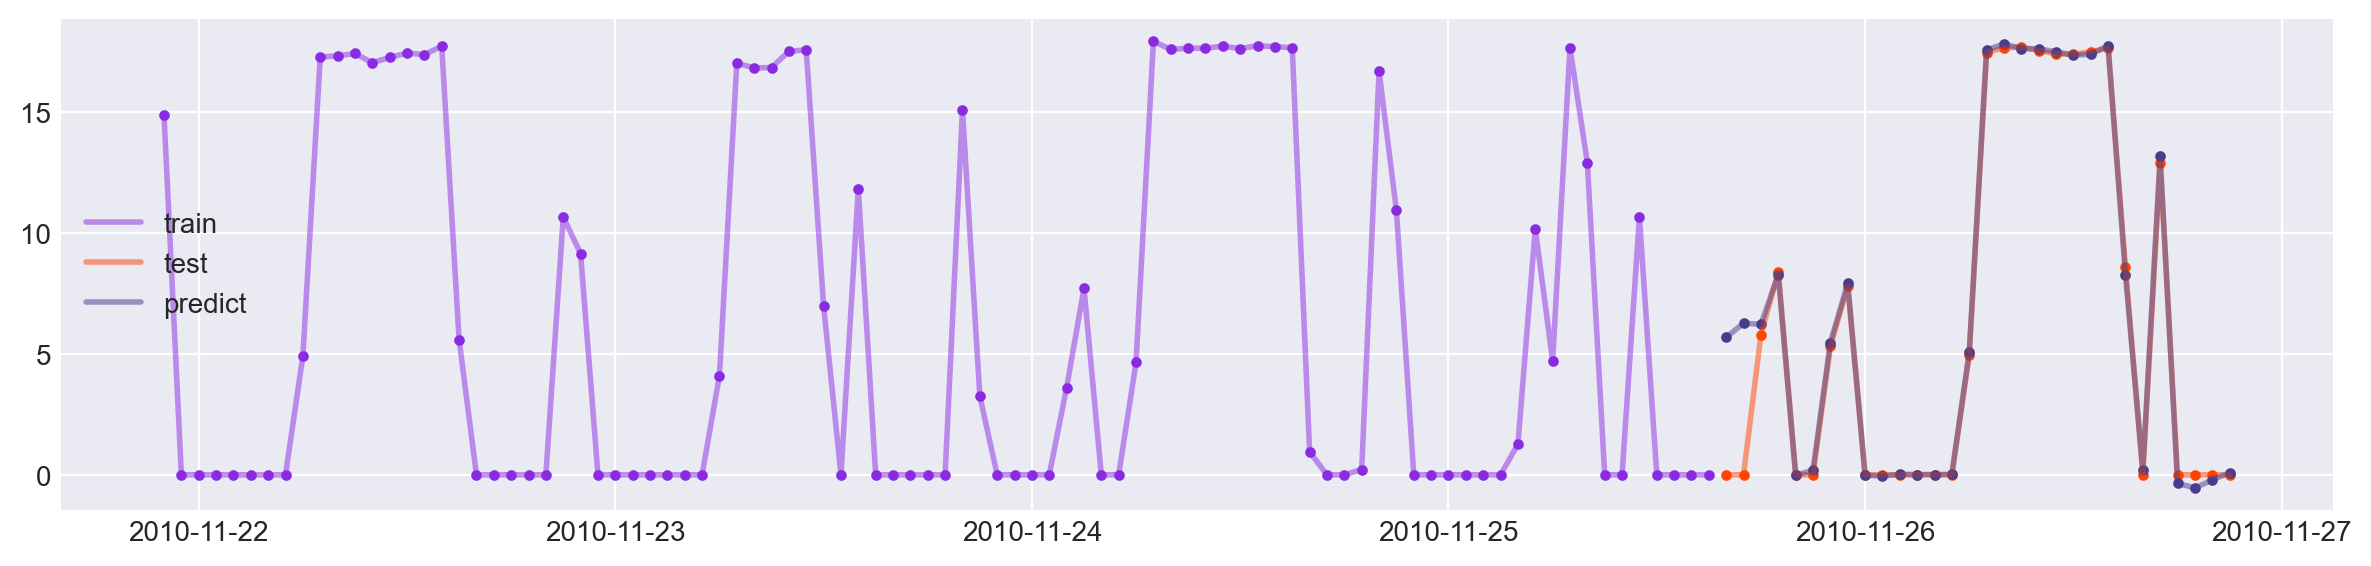

In [22]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [23]:
print(grid_search_results["params"])

{'l2_leaf_reg': 3}


In [24]:
del (
    train_data,
    test_data,
    train_data_feat,
    test_data_feat,
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 20

train_data, test_data = test_train_split(dataframe, test_size=WINDOW_LEN + 30)

build_features = lambda df: (
    df.pipe(create_lag_feature, column=target_column, lags=lags)
    .pipe(create_window_feature, column=target_column, window_len=window_length)
    .pipe(create_datetime_feature, features_name=dt_features)
    .pipe(create_cyclic_feature, features_name=cl_features)
    .pipe(cast_to_float)
)


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


train_data_feat = build_features(train_data)
test_data_feat = build_features(test_data)

train_data_feat = train_data_feat[max(*lags) :]
test_data_feat.fillna(method="backfill", inplace=True)


train_x, train_y = seperate_target(train_data_feat, target_column)
test_x, test_y = seperate_target(test_data_feat, target_column)

scaler = StandardScaler().set_output(transform="pandas")
scaler.fit(train_x)

train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

x_window = np.concatenate([train_x, test_x])
y_window = np.concatenate([train_y, test_y])


x_window, y_window = window_data(x_window, y_window, window_len=WINDOW_LEN)

x_train_data, x_test_data = x_window[: -len(test_x)], x_window[-len(test_x) :]
y_train_data, y_test_data = y_window[: -len(test_x)], y_window[-len(test_x) :]

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

model = tf.keras.models.Sequential(
    [
        LSTM(128, input_shape=x_window.shape[-2:], dropout=0.0),
        Dense(128),
        Dense(128),
        Dense(1),
    ]
)

model.compile(optimizer="rmsprop", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=EPOCHS_,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/20
200/200 [==============================] - 12s 42ms/step - loss: 16.1453 - mae: 2.8805 - val_loss: 128.2155 - val_mae: 9.9736
Epoch 2/20
200/200 [==============================] - 8s 42ms/step - loss: 3.0508 - mae: 1.2827 - val_loss: 6.5578 - val_mae: 1.9565
Epoch 3/20
200/200 [==============================] - 9s 43ms/step - loss: 1.6195 - mae: 0.9492 - val_loss: 4.2882 - val_mae: 1.0320
Epoch 4/20
200/200 [==============================] - 9s 44ms/step - loss: 0.7898 - mae: 0.6940 - val_loss: 3.8195 - val_mae: 0.9089
Epoch 5/20
200/200 [==============================] - 11s 54ms/step - loss: 0.6370 - mae: 0.6087 - val_loss: 3.7351 - val_mae: 0.6424
Epoch 6/20
200/200 [==============================] - 10s 51ms/step - loss: 0.4484 - mae: 0.4813 - val_loss: 4.3351 - val_mae: 0.9481
Epoch 7/20
200/200 [==============================] - 11s 56ms/step - loss: 0.4146 - mae: 0.4589 - val_loss: 4.3737 - val_mae: 0.6015
Epoch 8/20
200/200 [==============================] - 10s 51ms

In [26]:
resultsDict[model_name] = evaluate(y_test_data.flatten(), yhat.flatten())

predictionsDF[model_name] = yhat.flatten()[-len(predictionsDF.index) :]

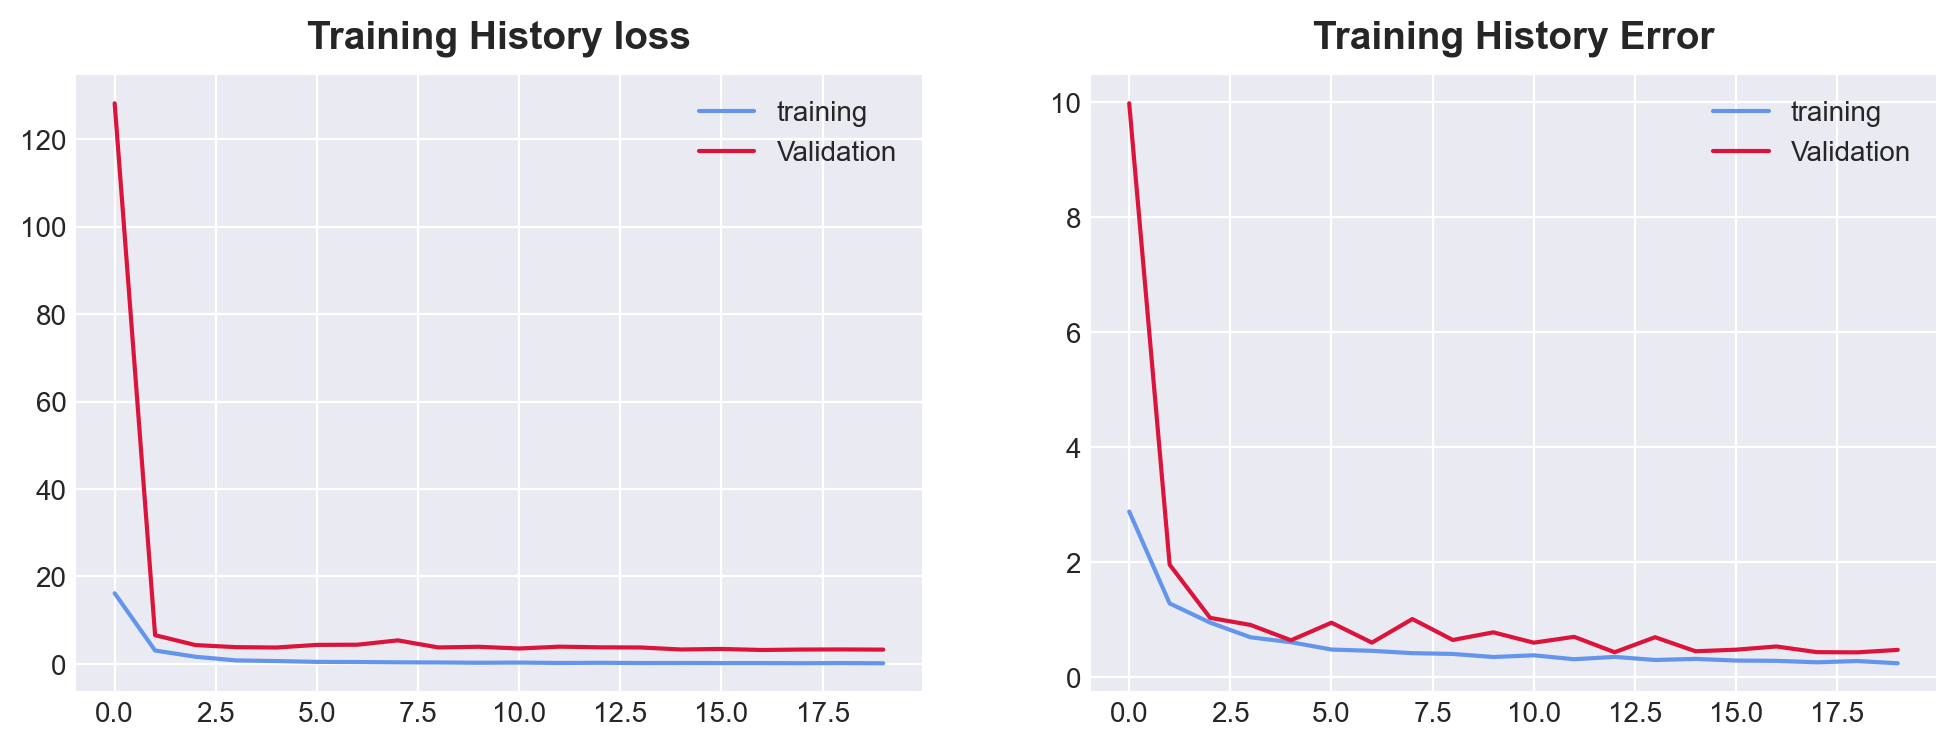

In [27]:
plot_tf_training_history(training_history)

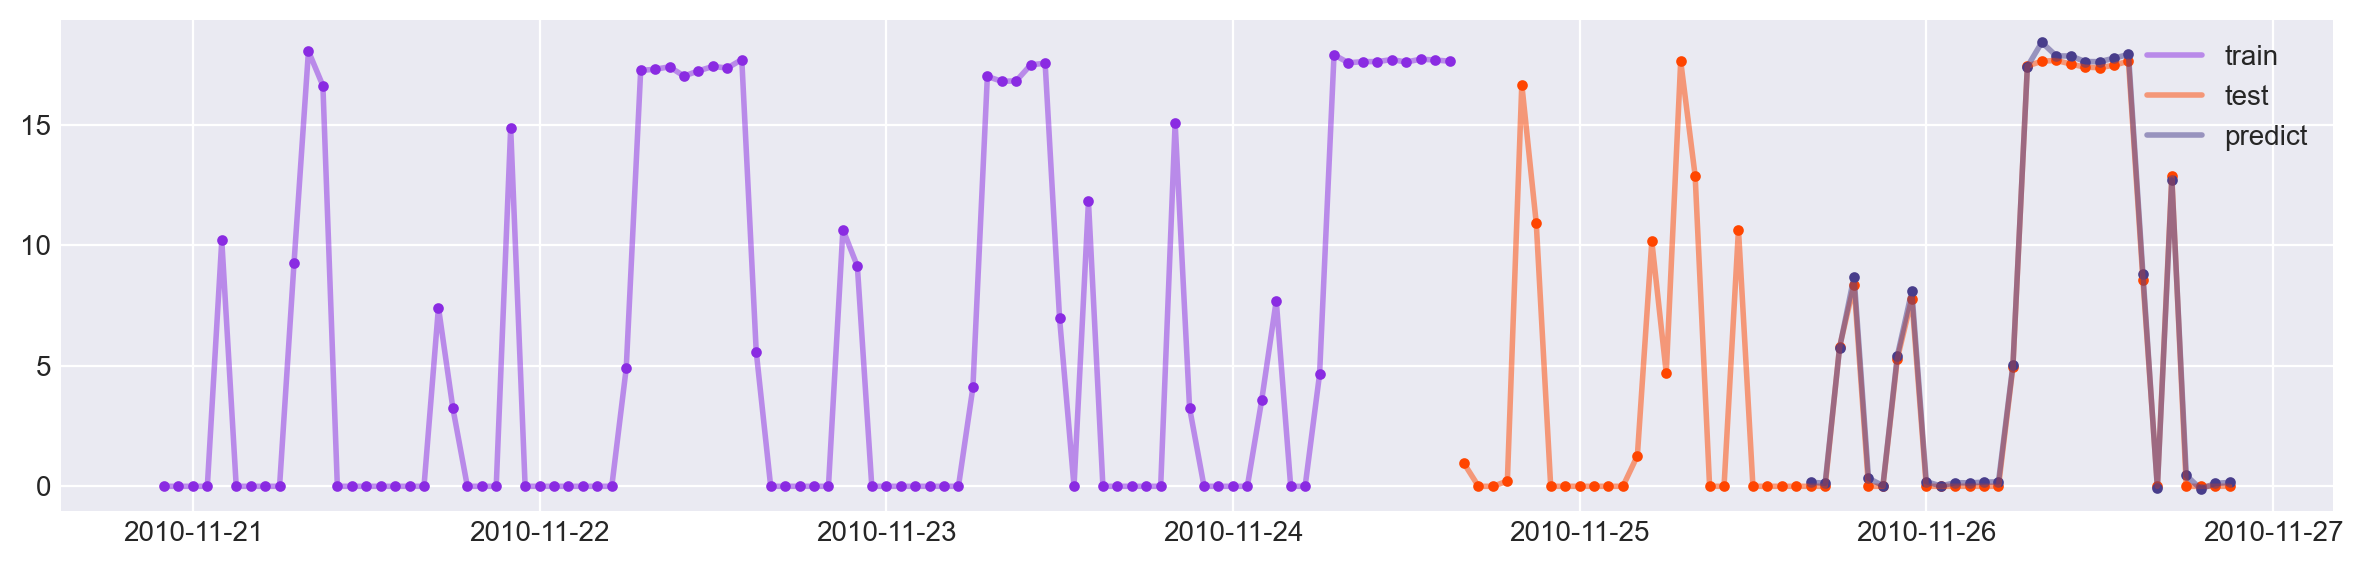

In [28]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [29]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,2.569444e+00,3.855556e-01,4.154110e-01,6.093069e-01,5.188642e-01,5.266269e-01,5.300989e-01,4.754882e-01
rmse,3.698920e+00,1.493250e+00,1.485747e+00,1.546374e+00,1.395423e+00,1.397446e+00,1.554535e+00,1.803806e+00
mape,1.779111e+10,3.855556e+09,3.992541e+09,4.904716e+09,4.007482e+09,4.164132e+09,4.554075e+09,1.078876e+09
r2,7.524796e-01,9.596609e-01,9.600652e-01,9.567397e-01,9.647732e-01,9.646710e-01,9.562818e-01,9.317673e-01


In [30]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,2.569444,3.698920,1.779111e+10,0.752480
BayesianRidge,0.385556,1.493250,3.855556e+09,0.959661
LassoCV,0.415411,1.485747,3.992541e+09,0.960065
RandomForestRegressor,0.609307,1.546374,4.904716e+09,0.956740
XGBRegressor,0.518864,1.395423,4.007482e+09,0.964773
LGBMRegressor,0.526627,1.397446,4.164132e+09,0.964671
CatBoostRegressor,0.530099,1.554535,4.554075e+09,0.956282
LSTM_Dense,0.475488,1.803806,1.078876e+09,0.931767


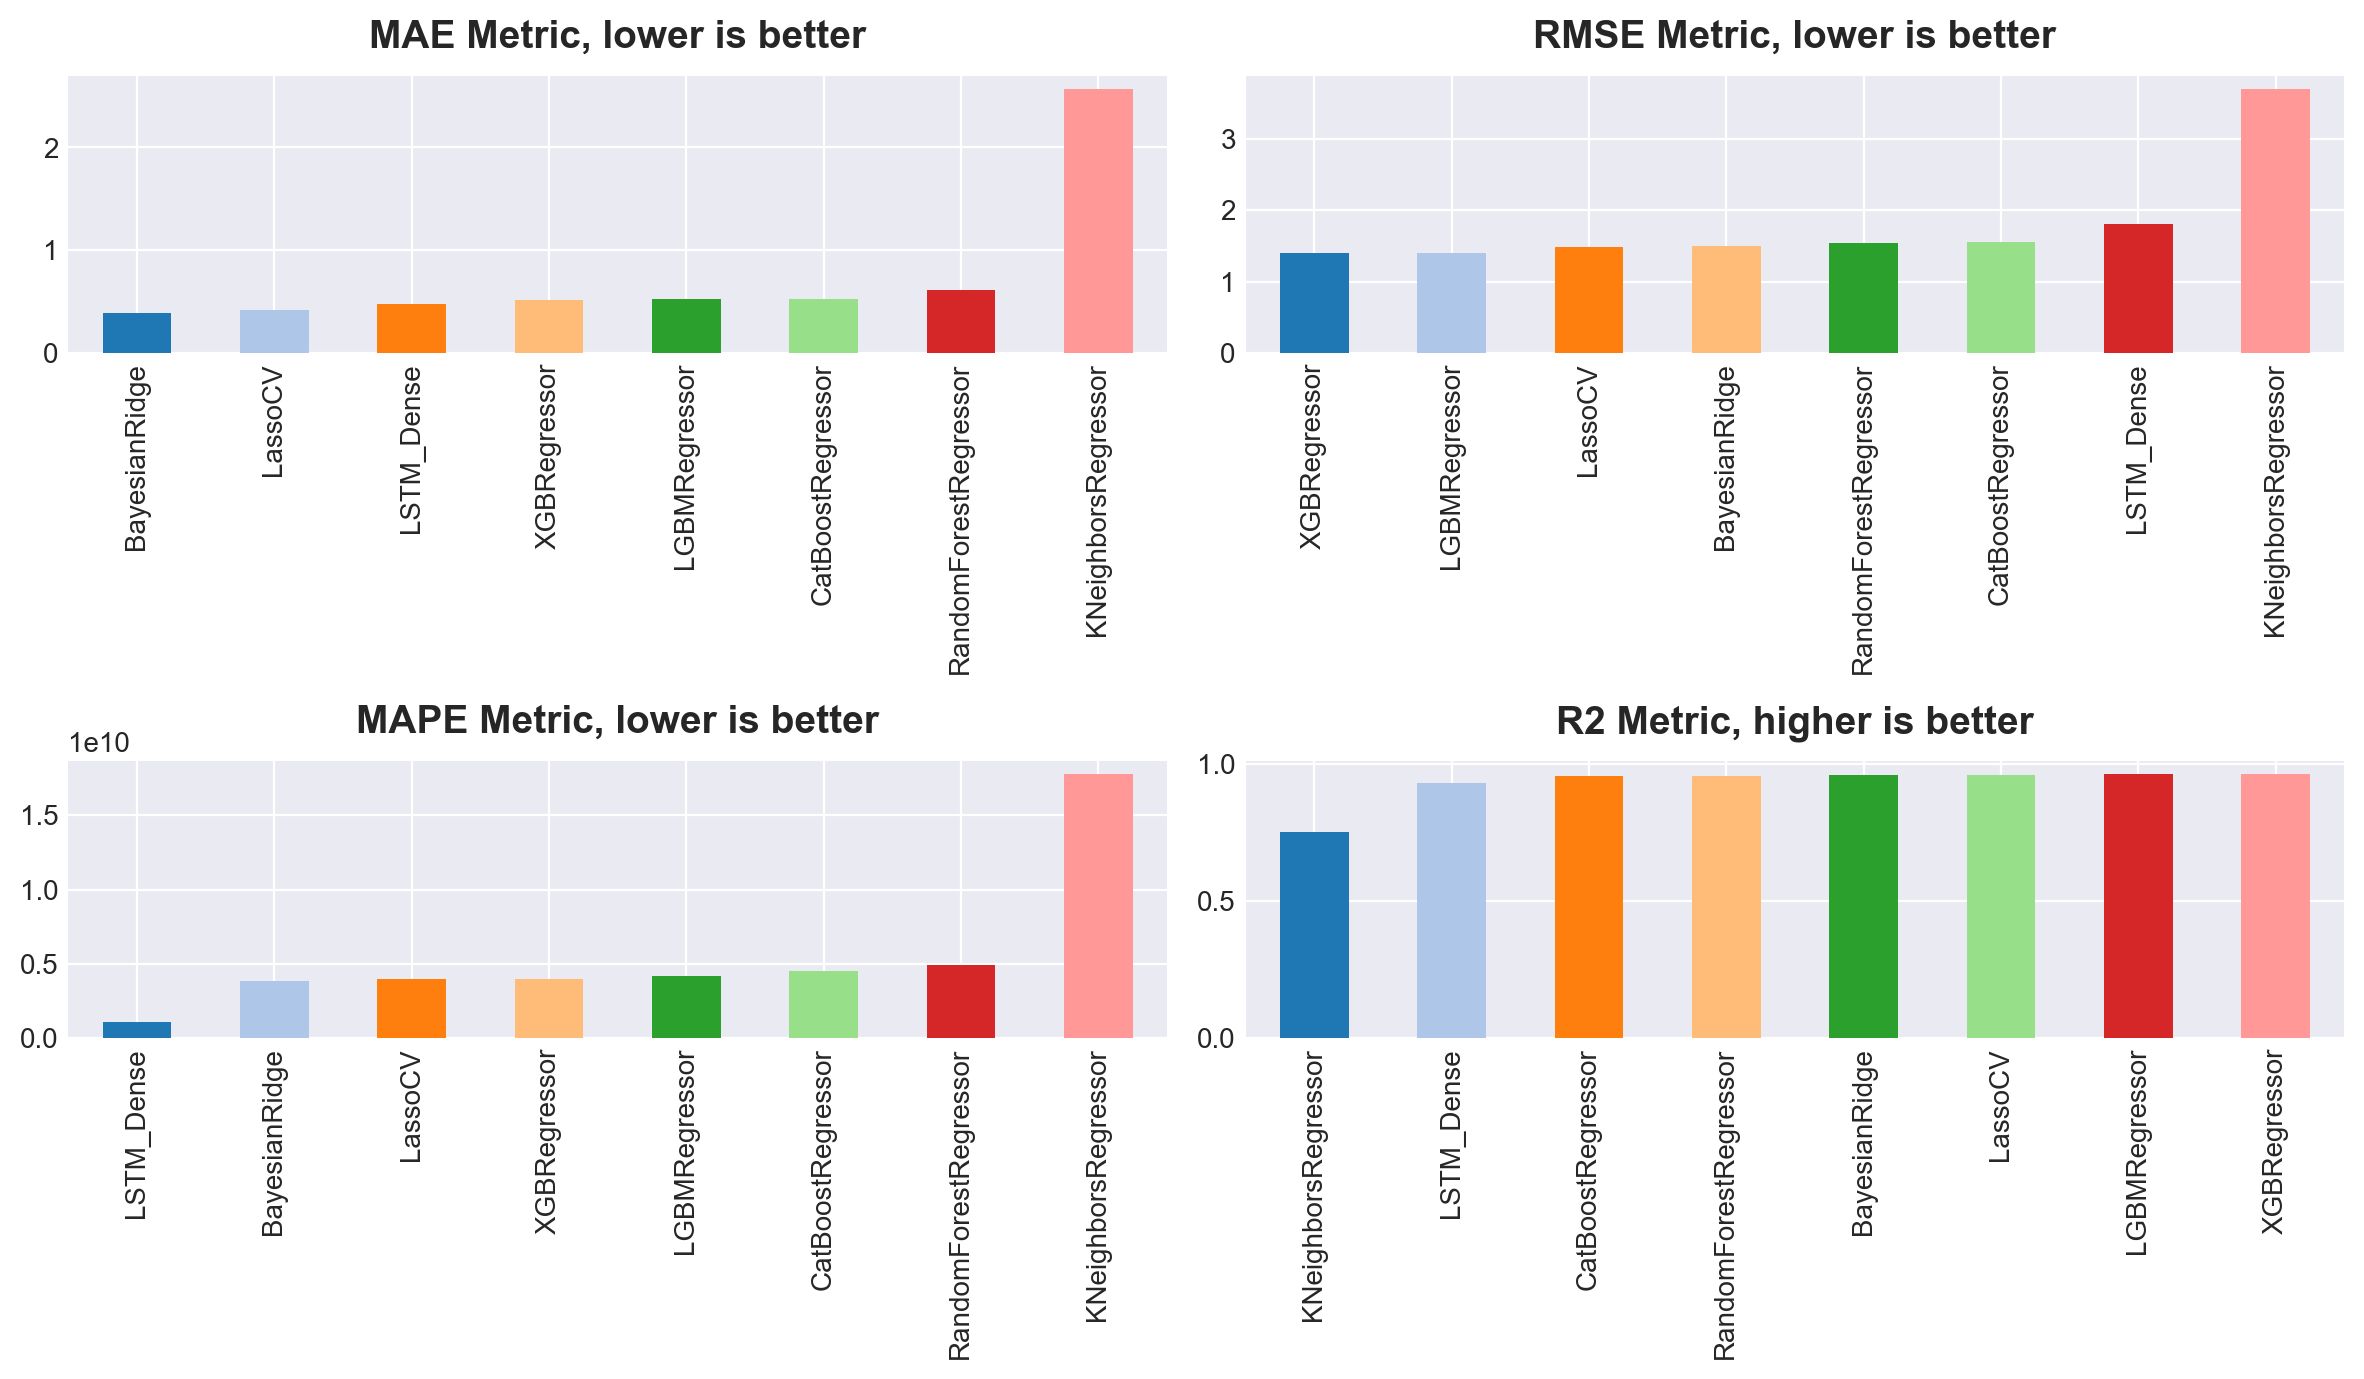

In [31]:
plot_metrics(resultsDF)

### Saving results

In [33]:
resultsDF_T = resultsDF.T.copy(deep=True)
resultsDF_T["Dataset"] = "Electricity"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"

if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Electricity"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Electricity"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)